## Capstone Project 2: 재고 관리를 위한 단기(6개월) 수요 예측 모델 생성

### Part 1. EDA

### 사용 데이터셋

> Forecasts for Product Demand: Make Accurate Forecasts for Thousands of Different Products
> - FelixZhao. kaggle. https://www.kaggle.com/felixzhao/productdemandforecasting
> - License: GPL 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 불러오기
historical_data = pd.read_csv('Historical Product Demand.csv')
historical_data.head()

Product_Code Warehouse Product_Category       Date Order_Demand
0  Product_0993    Whse_J     Category_028  2012/7/27         100 
1  Product_0979    Whse_J     Category_028  2012/1/19         500 
2  Product_0979    Whse_J     Category_028   2012/2/3         500 
3  Product_0979    Whse_J     Category_028   2012/2/9         500 
4  Product_0979    Whse_J     Category_028   2012/3/2         500

### 1. 데이터 전처리

In [3]:
# 컬럼명을 모두 소문자로 변경
historical_data.columns = [col.lower() for col in historical_data.columns]

In [4]:
# 결측치 확인
historical_data.isnull().sum()

product_code            0
warehouse               0
product_category        0
date                11239
order_demand            0
dtype: int64

In [5]:
# 결측치를 포함한 row 제거
historical_data = historical_data.dropna()

In [6]:
# order_demand 항목의 특수문자 제거
historical_data['order_demand'] =  historical_data['order_demand'].apply(lambda x: x.replace('(','').replace(')',''))

# order_demand, date 데이터 타입 변경
historical_data['order_demand'] = historical_data['order_demand'].astype('int')
historical_data['date'] = historical_data['date'].astype('datetime64')

In [7]:
# 제품의 개수 확인
print('제품 개수: ', len(historical_data.product_code.unique()))

# 카테고리의 개수 확인
print('카테고리 개수: ', len(historical_data.product_category.unique()))

# 창고의 개수 확인
print('창고 개수: ', len(historical_data.warehouse.unique()))

제품 개수:  2160
카테고리 개수:  33
창고 개수:  4


이번 프로젝트는 총 수요량을 예측하는 모델을 만드는 것을 목표로 한다. 따라서 각 주문 기록에서 창고에 대한 정보는 중요하지 않다고 판단하여 warehouse 컬럼을 제거하고, 같은 날 판매된 동일 제품의 판매 기록은 하나로 합쳐서 사용하기로 하였다.

In [8]:
# warehouse 삭제
historical_data = historical_data.drop('warehouse', axis=1)

In [9]:
# product_code와 date가 같은 기록 확인
historical_data[historical_data.duplicated(['product_code', 'date'])].shape

(454832, 4)

In [10]:
# 상품 정보 dataframe 생성 (product_code, product_category)
product_df = historical_data[['product_code', 'product_category']]

# 중복 row 제거
product_df = product_df.drop_duplicates(['product_code', 'product_category'])
product_df.head(3)

product_code product_category
0   Product_0993     Category_028
1   Product_0979     Category_028
16  Product_1159     Category_006

In [11]:
# 주문 기록 dataframe 생성 (각 제품의 날짜별 총 판매량)
order_df = historical_data.groupby(['product_code', 'date']).sum().reset_index()
order_df.head(3)

product_code       date  order_demand
0  Product_0001 2011-12-16           200
1  Product_0001 2011-12-20           100
2  Product_0001 2012-01-03          1000

In [12]:
# merge
historical_data = pd.merge(product_df, order_df, on='product_code', how='inner')

# 확인
print(historical_data.shape)
historical_data.head(3)

(582504, 4)


product_code product_category       date  order_demand
0  Product_0993     Category_028 2012-01-19           100
1  Product_0993     Category_028 2012-02-08           100
2  Product_0993     Category_028 2012-02-22           100

In [13]:
# date에서 year, month, quarter 추출 후 새로운 컬럼에 저장
historical_data['year'] = historical_data['date'].dt.year
historical_data['month'] = historical_data['date'].dt.month
historical_data['quarter'] = historical_data['date'].dt.quarter
historical_data

product_code product_category       date  order_demand  year  month  \
0       Product_0993     Category_028 2012-01-19           100  2012      1   
1       Product_0993     Category_028 2012-02-08           100  2012      2   
2       Product_0993     Category_028 2012-02-22           100  2012      2   
3       Product_0993     Category_028 2012-03-05           200  2012      3   
4       Product_0993     Category_028 2012-03-06           100  2012      3   
...              ...              ...        ...           ...   ...    ...   
582499  Product_0644     Category_019 2016-11-16             1  2016     11   
582500  Product_0644     Category_019 2016-11-21             3  2016     11   
582501  Product_0644     Category_019 2016-12-19             1  2016     12   
582502  Product_0644     Category_019 2016-12-28             5  2016     12   
582503  Product_0853     Category_021 2016-11-16            20  2016     11   

        quarter  
0             1  
1             1  
2             1  
3             1  
4             1  
...         ...  
582499        4  
582500        4  
582501        4  
582502        4  
582503        4  

[582504 rows x 7 columns]

In [14]:
# year, month 정보를 합친 column 생성
historical_data['YM'] = historical_data['date'].apply(lambda x: x.strftime('%Y-%m'))

# year, quarter 정보를 합친 column 생성
historical_data['YQ'] = historical_data.apply(lambda x: str(x['year'])+'-'+str(x['quarter']), axis=1)

# 확인
historical_data

product_code product_category       date  order_demand  year  month  \
0       Product_0993     Category_028 2012-01-19           100  2012      1   
1       Product_0993     Category_028 2012-02-08           100  2012      2   
2       Product_0993     Category_028 2012-02-22           100  2012      2   
3       Product_0993     Category_028 2012-03-05           200  2012      3   
4       Product_0993     Category_028 2012-03-06           100  2012      3   
...              ...              ...        ...           ...   ...    ...   
582499  Product_0644     Category_019 2016-11-16             1  2016     11   
582500  Product_0644     Category_019 2016-11-21             3  2016     11   
582501  Product_0644     Category_019 2016-12-19             1  2016     12   
582502  Product_0644     Category_019 2016-12-28             5  2016     12   
582503  Product_0853     Category_021 2016-11-16            20  2016     11   

        quarter       YM      YQ  
0             1  2012-01  2012-1  
1             1  2012-02  2012-1  
2             1  2012-02  2012-1  
3             1  2012-03  2012-1  
4             1  2012-03  2012-1  
...         ...      ...     ...  
582499        4  2016-11  2016-4  
582500        4  2016-11  2016-4  
582501        4  2016-12  2016-4  
582502        4  2016-12  2016-4  
582503        4  2016-11  2016-4  

[582504 rows x 9 columns]

In [15]:
# product_code, category 컬럼 표기 방식 int로 변환
historical_data['product_code'] = historical_data['product_code'].apply(lambda x: x.strip('Product_'))
historical_data['product_category'] = historical_data['product_category'].apply(lambda x: x.strip('Category_'))

historical_data['product_code'] = historical_data['product_code'].astype(int)
historical_data['product_category'] = historical_data['product_category'].astype(int)

In [16]:
# 확인
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582504 entries, 0 to 582503
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   product_code      582504 non-null  int64         
 1   product_category  582504 non-null  int64         
 2   date              582504 non-null  datetime64[ns]
 3   order_demand      582504 non-null  int64         
 4   year              582504 non-null  int64         
 5   month             582504 non-null  int64         
 6   quarter           582504 non-null  int64         
 7   YM                582504 non-null  object        
 8   YQ                582504 non-null  object        
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 44.4+ MB


In [17]:
# 제품 판매 기록 존재 유무 확인
cond = ['product_category', 'year', 'month']
temp_df = historical_data.groupby(cond).count().reset_index()[cond]
temp_df.head(3)

product_category  year  month
0                 1  2011      9
1                 1  2011     12
2                 1  2012      1

In [18]:
# 2011년 기록 확인
temp_df[temp_df['year'] == 2011]

product_category  year  month
0                    1  2011      9
1                    1  2011     12
92                   3  2011      5
93                   3  2011     12
154                  4  2011     12
203                  5  2011     12
265                  6  2011      1
266                  6  2011     11
267                  6  2011     12
329                  7  2011     10
330                  7  2011     11
331                  7  2011     12
453                  9  2011     11
454                  9  2011     12
575                 11  2011     10
576                 11  2011     12
688                 13  2011     12
771                 15  2011     12
908                 18  2011     12
969                 19  2011      6
970                 19  2011      9
971                 19  2011     10
972                 19  2011     11
973                 19  2011     12
1035                20  2011     12
1095                21  2011     11
1096                21  2011     12
1158                22  2011     12
1219                23  2011      9
1220                23  2011     12
1281                24  2011     12
1362                26  2011     12
1438                28  2011     11
1439                28  2011     12
1561                30  2011     12
1682                32  2011     12

In [19]:
# 2017년 기록 확인
temp_df[temp_df['year'] == 2017]

product_category  year  month
62                   1  2017      1
264                  5  2017      1
328                  6  2017      1
392                  7  2017      1
637                 11  2017      1
687                 12  2017      1
832                 15  2017      1
1034                19  2017      1
1094                20  2017      1
1157                21  2017      1
1423                26  2017      1
1500                28  2017      1

위 dataframe은 각 카테고리별 2011년과 2017년의 판매 기록 개수이다. `year`와 `month` column을 보면 알 수 있듯이, 2011년과 2017년은 모든 달에 판매 기록이 있는 게 아니다.

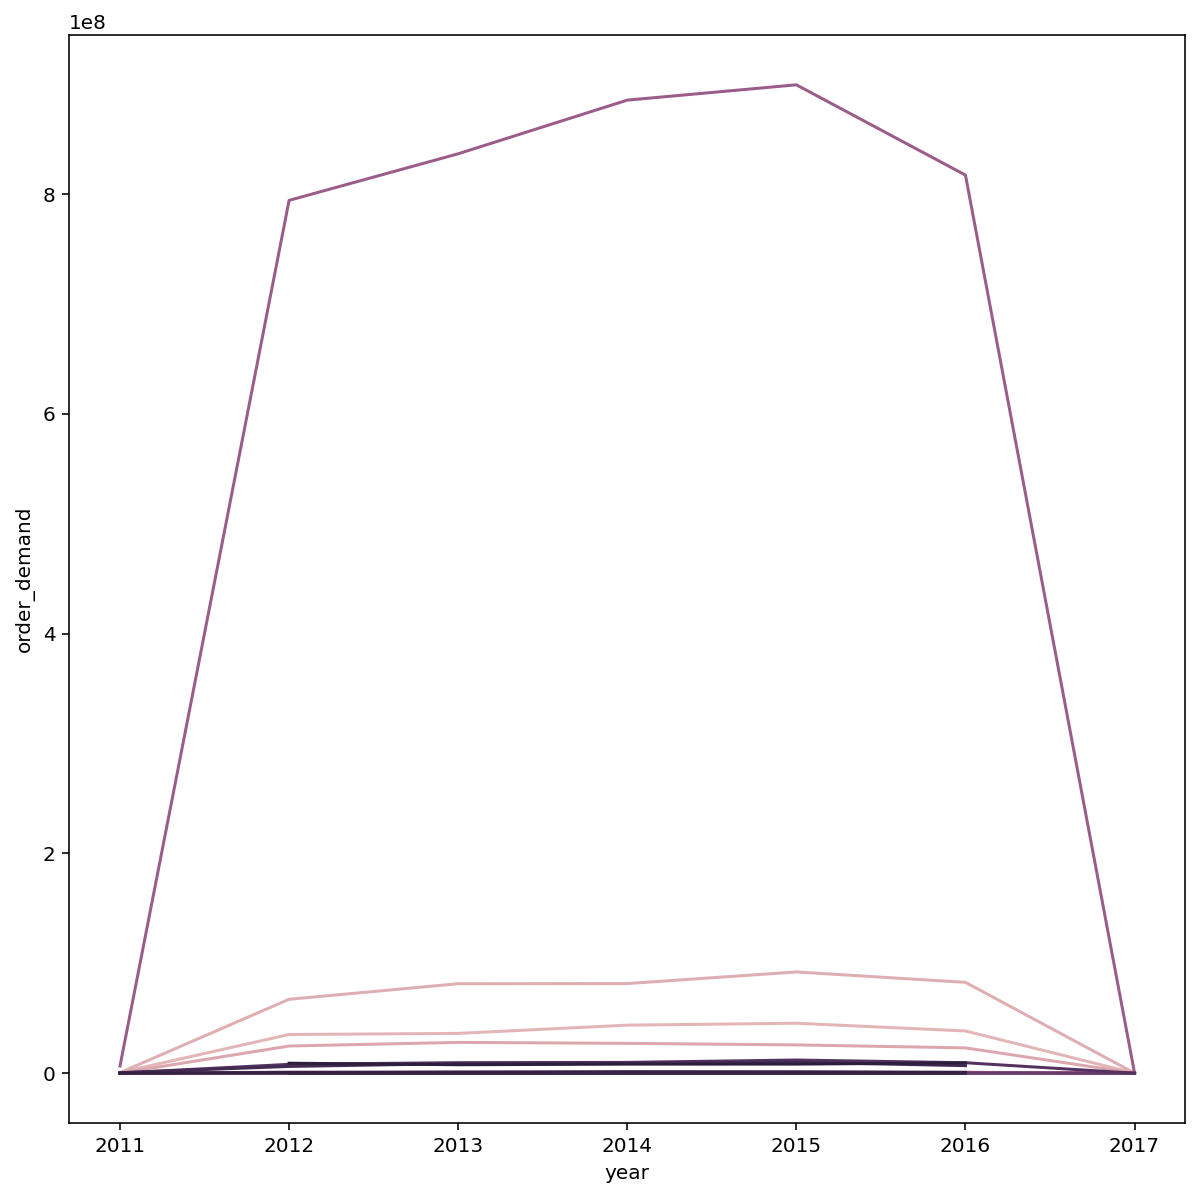

In [20]:
temp_df2 = historical_data.groupby(['product_category', 'year']).sum()[['order_demand']].reset_index()

plt.figure(figsize=(10, 10))
g = sns.lineplot(data=temp_df2, x='year', y='order_demand', hue='product_category')
plt.legend([],[], frameon=False);

위 그래프는 각 카테고리에 대해서 연도별 판매 기록의 개수를 시각화한 것이다. 2011년과 2017년은 판매 기록이 모든 달에 대해서 존재하지 않았고, 이 때문에 2011년과 2017년의 판매 기록은 다른 연도에 비해서 월등하게 적다는 것을 위의 그래프로도 확인할 수 있다. 따라서 모든 달에 대해서 기록이 존재하는 2012 ~ 2016년의 데이터만 사용하기로 하였다.

In [21]:
# 2011, 2017년 데이터 제거
historical_data = historical_data.drop(historical_data[(historical_data['year'] == 2011)].index)
historical_data = historical_data.drop(historical_data[(historical_data['year'] == 2017)].index)

historical_data = historical_data.reset_index(drop=True)

In [22]:
# 확인
historical_data['year'].unique()

array([2012, 2013, 2014, 2015, 2016])

In [23]:
# 카테고리별 연 판매량
temp_df = historical_data.groupby(['product_category', 'year']).sum()[['order_demand']].reset_index()
temp_df.pivot(index='product_category', columns='year')

order_demand                                         \
year                     2012         2013         2014         2015   
product_category                                                       
1                    275607.0     320250.0     369620.0     389403.0   
2                         NaN        201.0        204.0        223.0   
3                     75056.0      92937.0      82232.0      94320.0   
4                     23810.0      26401.0      25176.0      20879.0   
5                  35198945.0   36201555.0   43707445.0   45454520.0   
6                  67259055.0   81419576.0   81544531.0   92122245.0   
7                  24717088.0   28037572.0   27132962.0   25740371.0   
8                      3680.0       2826.0       3544.0       4341.0   
9                    747277.0     840534.0     825505.0     903441.0   
10                     4539.0       3539.0       3510.0       6538.0   
11                   464576.0     510904.0     543227.0     555247.0   
12                       17.0        690.0      10169.0      32719.0   
13                    55185.0     105084.0      66758.0      56400.0   
14                        NaN         24.0          8.0         57.0   
15                   172438.0     160946.0     158397.0     194540.0   
16                        NaN          NaN          NaN      15228.0   
17                     2611.0      25197.0       5707.0       6126.0   
18                     8216.0      10605.0       9920.0       9658.0   
19                794333297.0  836719055.0  885560884.0  899484133.0   
20                   397514.0     480075.0     589973.0     663675.0   
21                   912381.0     946535.0     901625.0    1002702.0   
22                   102692.0     115182.0     189703.0     135605.0   
23                   351534.0     880883.0     710857.0     858734.0   
24                   211500.0     225425.0     211676.0     240532.0   
25                    15000.0     147000.0     253000.0      71000.0   
26                    61958.0      52433.0      66202.0      56234.0   
27                        NaN          NaN          1.0         66.0   
28                  8051930.0    9563379.0    9833248.0   11979274.0   
29                     7665.0       6172.0       3257.0       2813.0   
30                  6140201.0    8719651.0    8819104.0    9969314.0   
31                     3215.0       3287.0       2104.0       2269.0   
32                   583004.0     790004.0    1307818.0    1065784.0   
33                  9080000.0    7680000.0    8240000.0    8260000.0   

                               
year                     2016  
product_category               
1                    401567.0  
2                         NaN  
3                     46697.0  
4                         NaN  
5                  38427705.0  
6                  82665414.0  
7                  23032502.0  
8                      3177.0  
9                    463807.0  
10                     4428.0  
11                   818340.0  
12                    26341.0  
13                    25784.0  
14                       11.0  
15                   147780.0  
16                     1622.0  
17                     9816.0  
18                     7617.0  
19                817323793.0  
20                   248155.0  
21                   708855.0  
22                    61763.0  
23                   527066.0  
24                   167898.0  
25                        NaN  
26                    45126.0  
27                       36.0  
28                  9510697.0  
29                     4072.0  
30                  6852785.0  
31                     2147.0  
32                   705398.0  
33                  9350000.0

- 기록이 너무 적다고 판단되는 카테고리: 2, 12 14, 16, 27
- 단종되었다고 판단한 카테고리 (2015년 이후 판매 기록이 없으므로 단종되었다고 판단): 4,  25

따라서, 위 카테고리들은 제거하기로 하였다.

In [24]:
cond = historical_data[historical_data['product_category'].isin([
                                       2,
                                       12,
                                       14,
                                       16,
                                       27,
                                       4,
                                       25])].index
historical_data = historical_data.drop(cond)
historical_data.head(3)

product_code  product_category       date  order_demand  year  month  \
0           993                28 2012-01-19           100  2012      1   
1           993                28 2012-02-08           100  2012      2   
2           993                28 2012-02-22           100  2012      2   

   quarter       YM      YQ  
0        1  2012-01  2012-1  
1        1  2012-02  2012-1  
2        1  2012-02  2012-1

### 2. EDA

#### a. 데이터 파악

In [25]:
# 각 제품의 주문 횟수
historical_data['product_code'].value_counts() # 총 제품 개수: 2,125개

349     1293
620     1282
33      1268
1470    1267
1241    1261
        ... 
1912       2
1698       2
1703       1
853        1
2099       1
Name: product_code, Length: 2125, dtype: int64

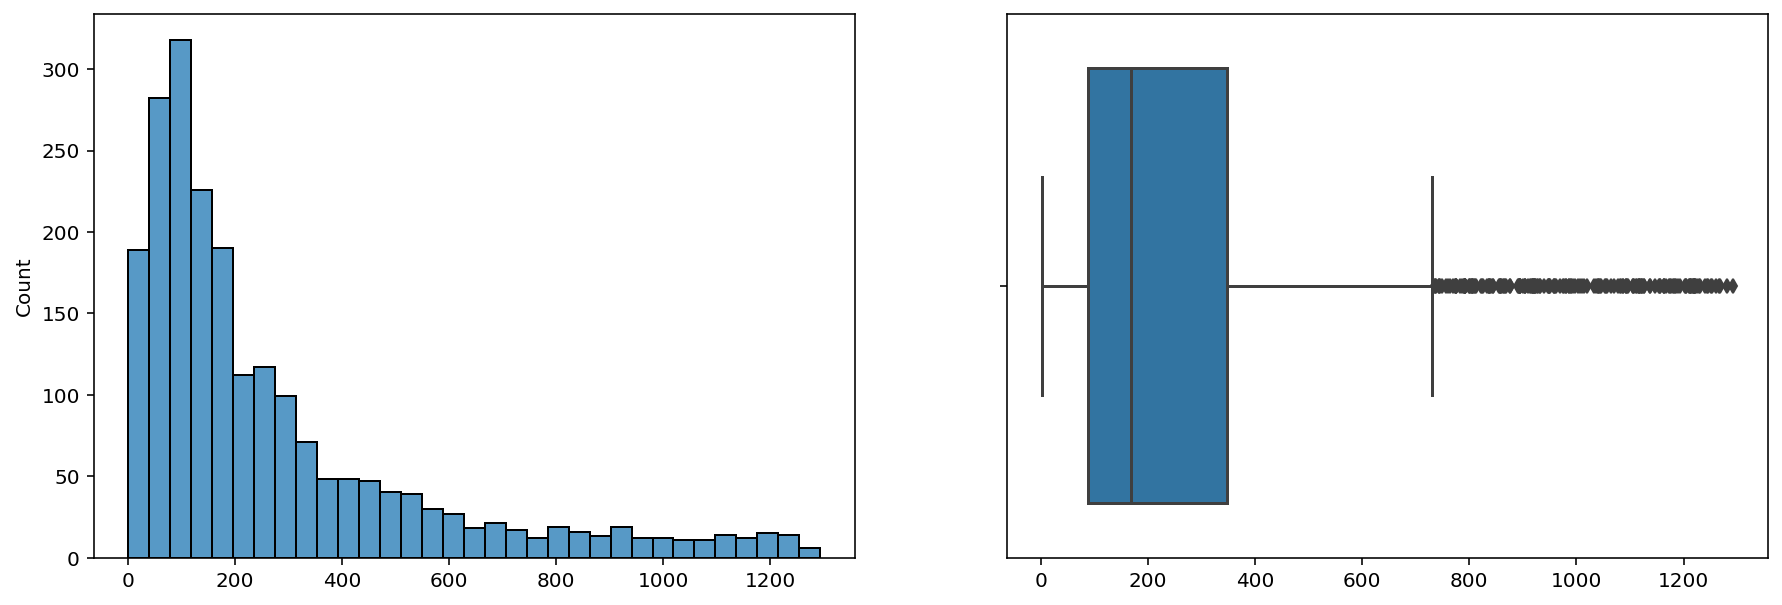

In [26]:
# 제품별 주문 횟수 총 합 시각화
plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.histplot(historical_data['product_code'].value_counts().values)

plt.subplot(122)
sns.boxplot(historical_data['product_code'].value_counts().values);

위 그래프는 제품별 주문 횟수를 히스토그램과 박스 플롯으로 시각화한 것이다.

In [27]:
# 제품 카테고리 개수 확인
print(len(historical_data['product_category'].value_counts())) # 26개

26


In [28]:
# 카테고리별 주문 횟수
historical_data['product_category'].value_counts()

19    205498
1      64331
5      60066
7      47486
21     36754
6      25901
28     18956
15     16009
11     15277
9      14671
24     14040
30     11122
26     10429
32      7727
22      7208
23      6030
18      3785
3       3030
13      2981
20      2802
31      1750
33      1478
8       1290
10       816
29       611
17       540
Name: product_category, dtype: int64

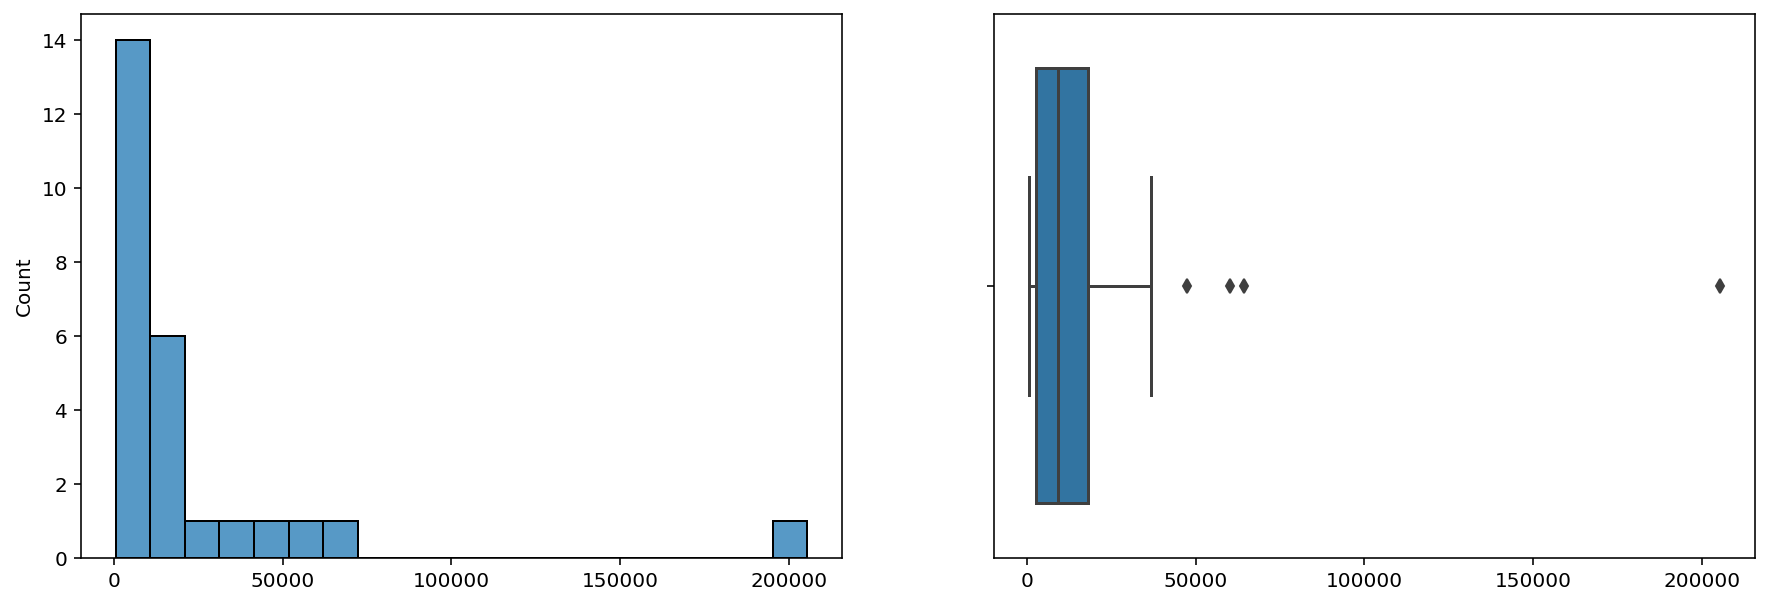

In [29]:
# 카테고리별 주문 횟수 총 합 시각화
plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.histplot(historical_data['product_category'].value_counts().values)

plt.subplot(122)
sns.boxplot(historical_data['product_category'].value_counts().values);

위 그림은 카테고리별 주문 횟수를 히스토그램과 박스플롯으로 시각화한 것이다. 주문 횟수가 200,000번이 넘는 카테고리가 존재한다. 자주 팔리는 상품과 카테고리는 회사에게 중요한 항목이다. 따라서, 주문 횟수가 다른 것들에 비해서 월등히 많다고 해서 이상치라고 보고 제거할 수는 없다.

#### b. 각 카테고리, 제품의 월별 수요량 시각화

##### 1) 각 카테고리의 월별 총 수요량 시각화

In [30]:
# 월 단위
temp_df_month = historical_data.groupby(['product_category','YM']).sum()
temp_df_month = temp_df_month.sort_index(ascending=True)
temp_df_month = temp_df_month.reset_index()
temp_df_month = temp_df_month.drop(['product_code','year', 'month','quarter'], axis=1)

print(temp_df_month.shape)
temp_df_month.head()

(1558, 3)


product_category       YM  order_demand
0                 1  2012-01         22289
1                 1  2012-02         26334
2                 1  2012-03         30608
3                 1  2012-04         21431
4                 1  2012-05         20422

In [31]:
# 주문 기록이 없는 달은 0으로 채우기
temp_df_month = temp_df_month.pivot(index='YM', columns='product_category', values='order_demand').fillna(0)
temp_df_month = temp_df_month.unstack().rename('order_demand').reset_index()

print(temp_df_month.shape)
temp_df_month.head()

(1560, 3)


product_category       YM  order_demand
0                 1  2012-01       22289.0
1                 1  2012-02       26334.0
2                 1  2012-03       30608.0
3                 1  2012-04       21431.0
4                 1  2012-05       20422.0

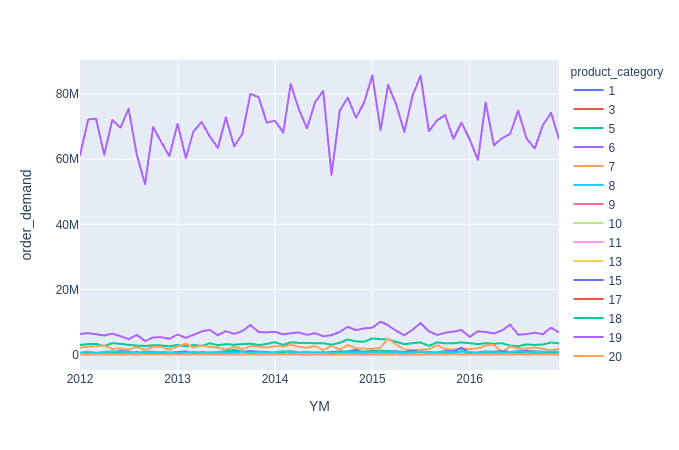

In [32]:
# 각 카테고리의 월별 수요 시각화 (Category-wise Daily Order Demand)
fig = px.line(temp_df_month, x="YM", y='order_demand', color='product_category')
fig.show()

In [33]:
temp_df_month.head(3)

product_category       YM  order_demand
0                 1  2012-01       22289.0
1                 1  2012-02       26334.0
2                 1  2012-03       30608.0

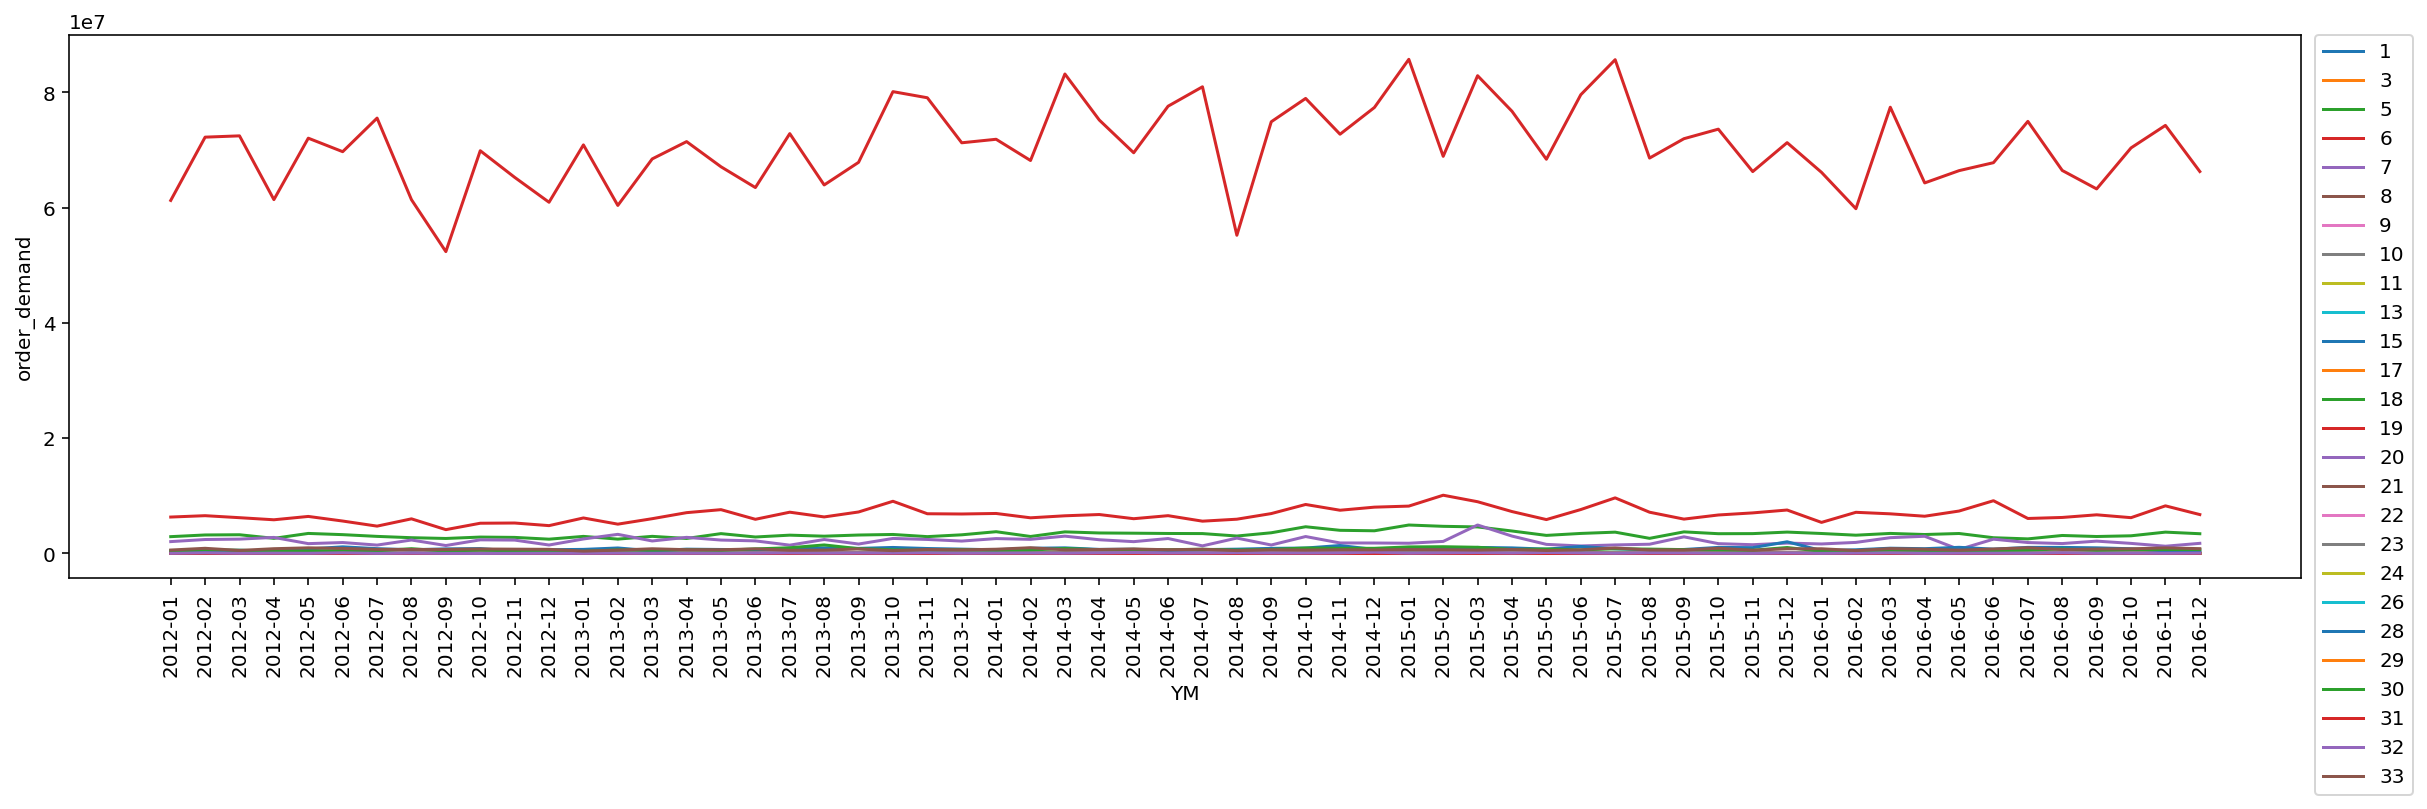

In [34]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=temp_df_month, x="YM", y='order_demand', hue='product_category', palette='tab10')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.show();

카테고리 19의 판매량이 월등하게 많아서 위 그림에서는 다른 카테고리들의 수요량 차이가 두드러지지 않는다. 따라서, 카테고리 19를 제외한 그래프를 그려보기로 하였다.

In [35]:
month_excl_19 = temp_df_month[temp_df_month["product_category"]!=19]

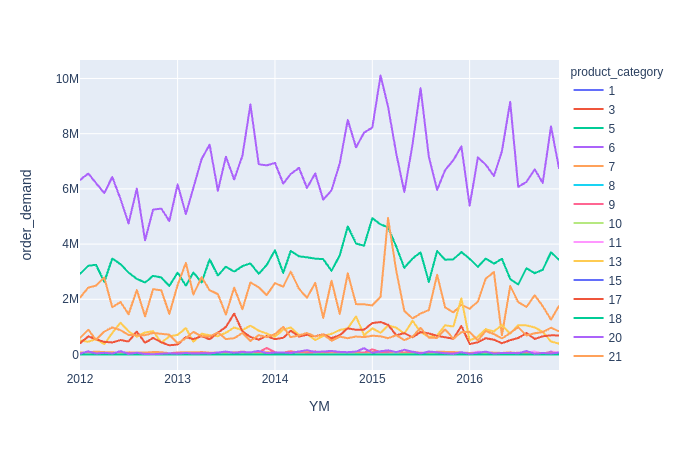

In [36]:
# 카테고리 19를 제외한 각 카테고리의 월별 수요 시각화 (Category-wise Monthly Order Demand (019 excluded))
fig = px.line(month_excl_19, x="YM", y='order_demand', color='product_category')
fig.show()

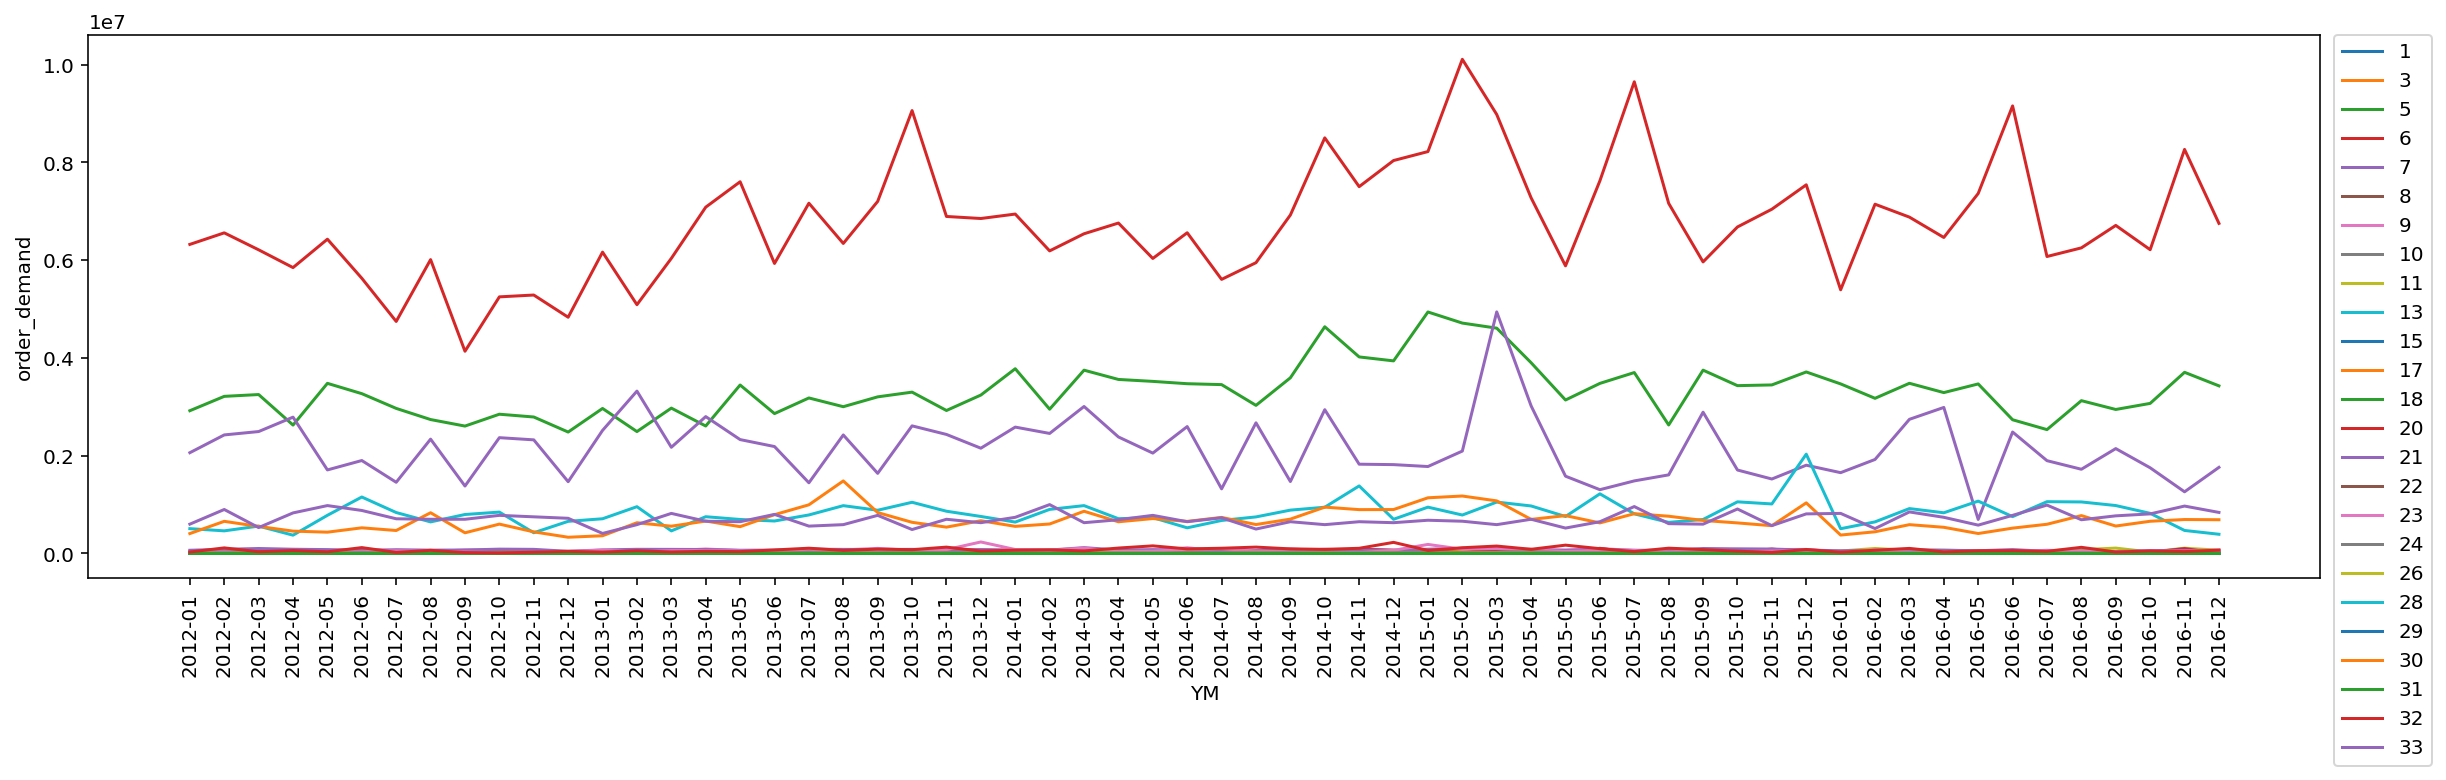

In [37]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=month_excl_19, x="YM", y='order_demand', hue='product_category', palette='tab10')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.show();

위의 그래프를 보면, 카테고리 6(빨간색), 5(초록색), 7(보라색)이 비슷한 트렌드를 가진 것 같다.

##### 2) 카테고리끼리의 상관관계 확인

###### a) 카테고리 6, 19

In [38]:
cat_19 = temp_df_month[temp_df_month["product_category"] == 19]
cat_6 = temp_df_month[temp_df_month["product_category"] == 6]

cat_196 = pd.concat([cat_19, cat_6])

pivot_196 = pd.pivot_table(cat_196, values='order_demand', index=['YM'], columns=['product_category'], aggfunc=np.sum)

Text(0.5, 1.0, 'Cat 19 vs Cat 6')

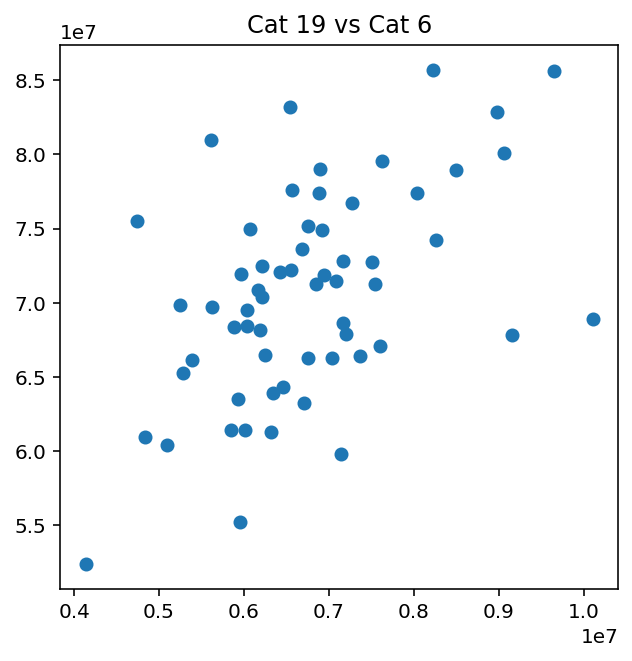

In [39]:
plt.figure(figsize=(5, 5))

plt.scatter(pivot_196[6],pivot_196[19])
plt.title('Cat 19 vs Cat 6')

In [40]:
print('Cat 6 vs Cat 19 r-score:',pivot_196[6].corr(pivot_196[19]))

Cat 6 vs Cat 19 r-score: 0.5079887492611027


카테고리 6과 19의 r-score는 약 0.51이다. 이 둘은 약한 선형 상관관계를 가지고 있다고 할 수 있다.

###### b) 카테고리 6, 5, 7

In [41]:
cat_5 = temp_df_month[temp_df_month["product_category"] == 5]
cat_6 = temp_df_month[temp_df_month["product_category"] == 6]
cat_7 = temp_df_month[temp_df_month["product_category"] == 7]

cat_657 = pd.concat([cat_5, cat_6])
cat_657 = pd.concat([cat_657,cat_7])
cat_657

product_category       YM  order_demand
120                 5  2012-01     2920345.0
121                 5  2012-02     3213850.0
122                 5  2012-03     3251070.0
123                 5  2012-04     2626790.0
124                 5  2012-05     3480100.0
..                ...      ...           ...
295                 7  2016-08     1722838.0
296                 7  2016-09     2145667.0
297                 7  2016-10     1753002.0
298                 7  2016-11     1261750.0
299                 7  2016-12     1761707.0

[180 rows x 3 columns]

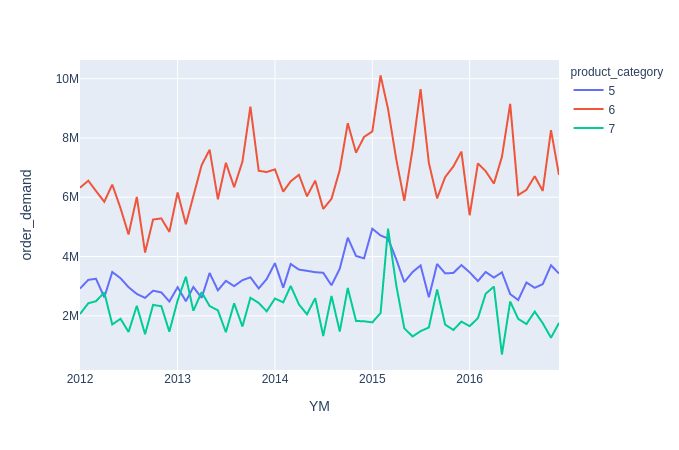

In [42]:
# Top 2~4
fig = px.line(cat_657, x="YM", y='order_demand', color='product_category')
fig.show()

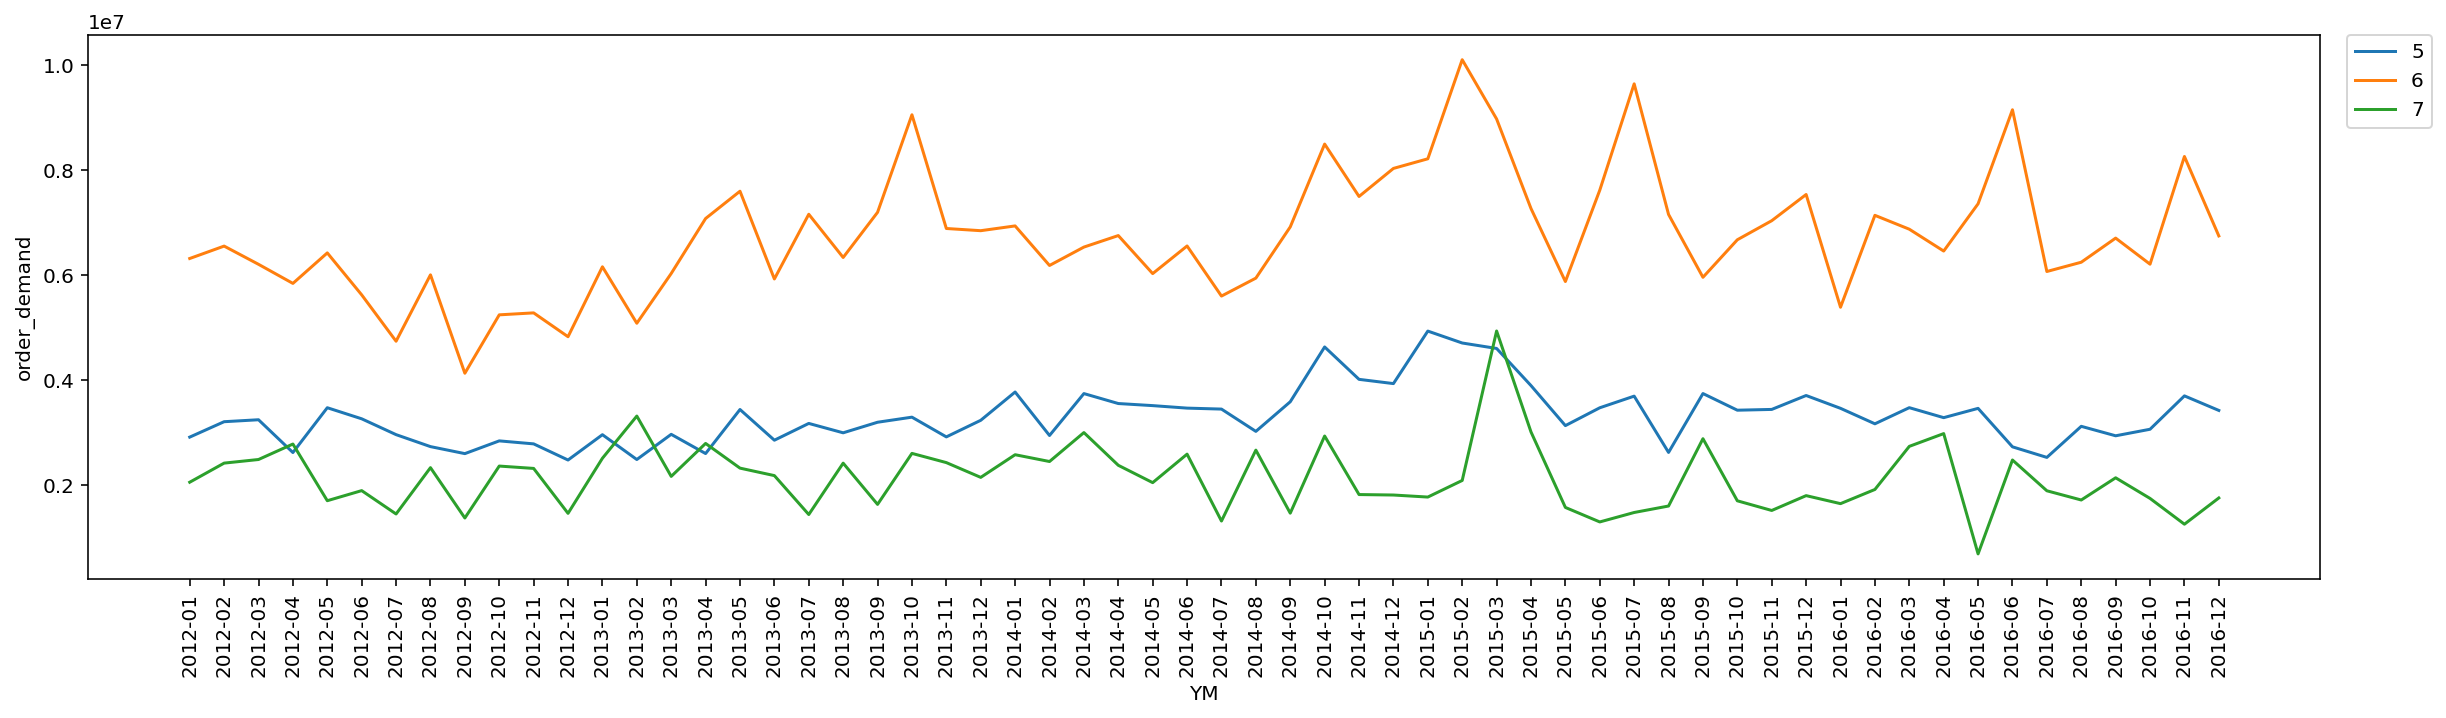

In [43]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=cat_657, x="YM", y='order_demand', hue='product_category', palette='tab10')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.show();

In [44]:
pivot_657 = pd.pivot_table(cat_657, values='order_demand', index=['YM'], columns=['product_category'], aggfunc=np.sum)

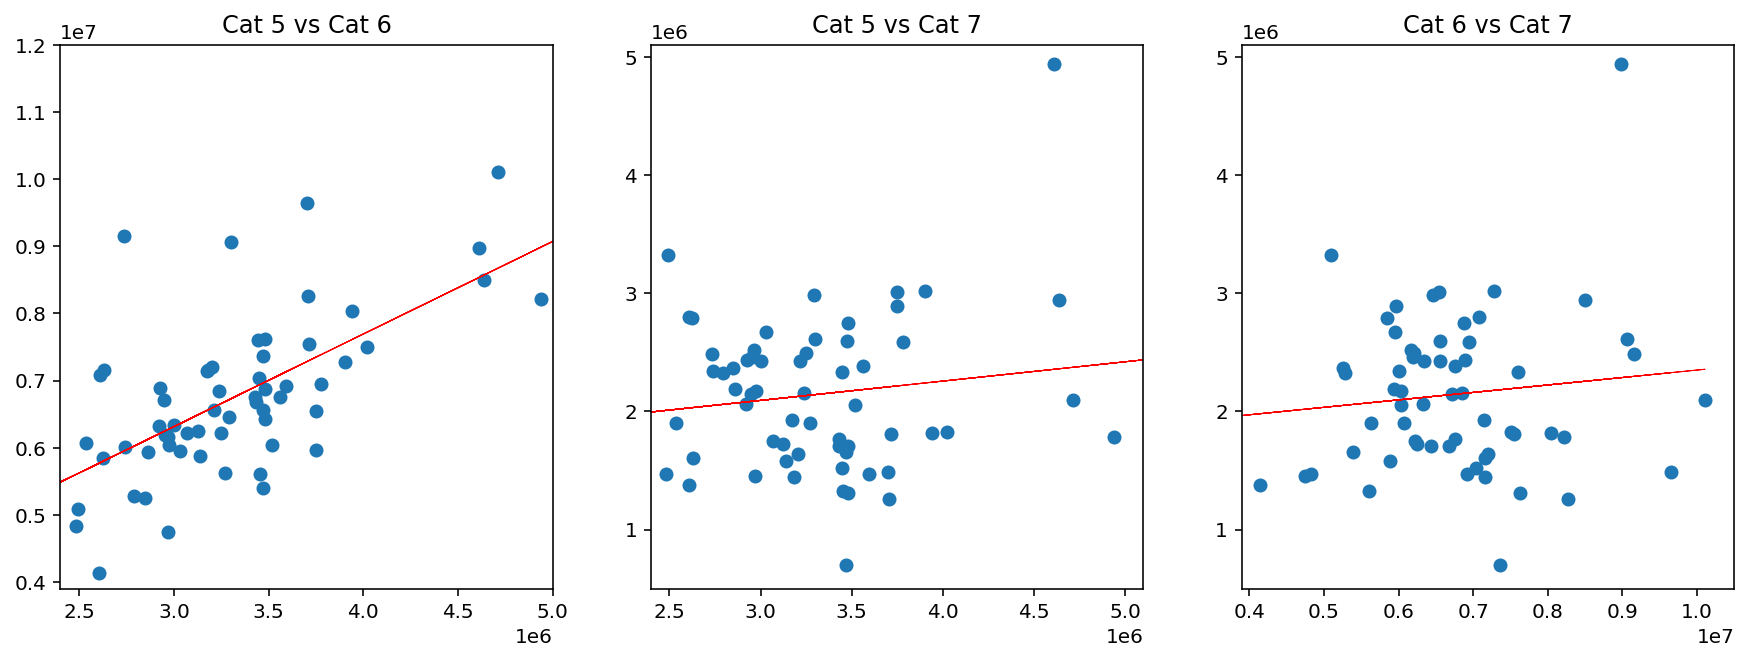

In [45]:
plt.figure(figsize=(15, 5))

x = pivot_657.reset_index().drop("YM", axis=1)

plt.subplot(131)
plt.scatter(pivot_657[5],pivot_657[6])
m, b = np.polyfit(pivot_657[5], pivot_657[6], 1)
plt.plot(x, m*x+b, 'r', linewidth=0.5)
plt.xlim(2400000, 5000000)
plt.ylim(3900000, 12000000)

plt.title('Cat 5 vs Cat 6')

plt.subplot(132)
plt.scatter(pivot_657[5],pivot_657[7])
m, b = np.polyfit(pivot_657[5], pivot_657[7], 1)
plt.plot(x, m*x+b, 'r', linewidth=0.5)
plt.xlim(2400000, 5100000)
plt.ylim(500000, 5100000)

plt.title('Cat 5 vs Cat 7')

plt.subplot(133)
plt.scatter(pivot_657[6], pivot_657[7])
m, b = np.polyfit(pivot_657[6], pivot_657[7], 1)
plt.plot(x, m*x+b, 'r', linewidth=0.5)
plt.xlim(3900000, 10500000)
plt.ylim(500000, 5100000)

plt.title('Cat 6 vs Cat 7');

In [46]:
print('Cat 5 vs Cat 6 r-score:',pivot_657[5].corr(pivot_657[6]))
print('Cat 5 vs Cat 7 r-score:',pivot_657[5].corr(pivot_657[7]))
print('Cat 6 vs Cat 7 r-score:',pivot_657[7].corr(pivot_657[6]))

Cat 5 vs Cat 6 r-score: 0.630028192965123
Cat 5 vs Cat 7 r-score: 0.133974656692798
Cat 6 vs Cat 7 r-score: 0.11316111558020021


카테고리 6과 5의 r-score는 약 0.63으로, 둘 사이에는 강한 양의 선형 상관관계가 있다고 할 수 있다. 따라서, 카테고리 6과 5의 증감의 트렌드는 유사하다고 볼 수 있다. 하지만, 카테고리 5와 7, 그리고 카테고리 6과 7의 r-score는 약 0.11로, 이들 사이에는 선형 상관관계를 거의 찾을 수 없다.

###### c) 카테고리 28, 30, 33

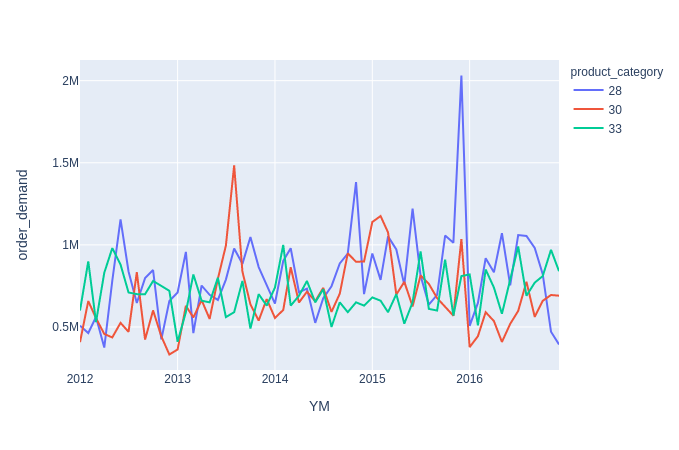

In [47]:
cat_28 = temp_df_month[temp_df_month["product_category"] == 28]
cat_30 = temp_df_month[temp_df_month["product_category"] == 30]
cat_33 = temp_df_month[temp_df_month["product_category"] == 33]

cat_283033 = pd.concat([cat_28, cat_30])
cat_283033 = pd.concat([cat_283033,cat_33])
cat_283033

# Mid_3
fig = px.line(cat_283033, x="YM", y='order_demand', color='product_category')
fig.show();

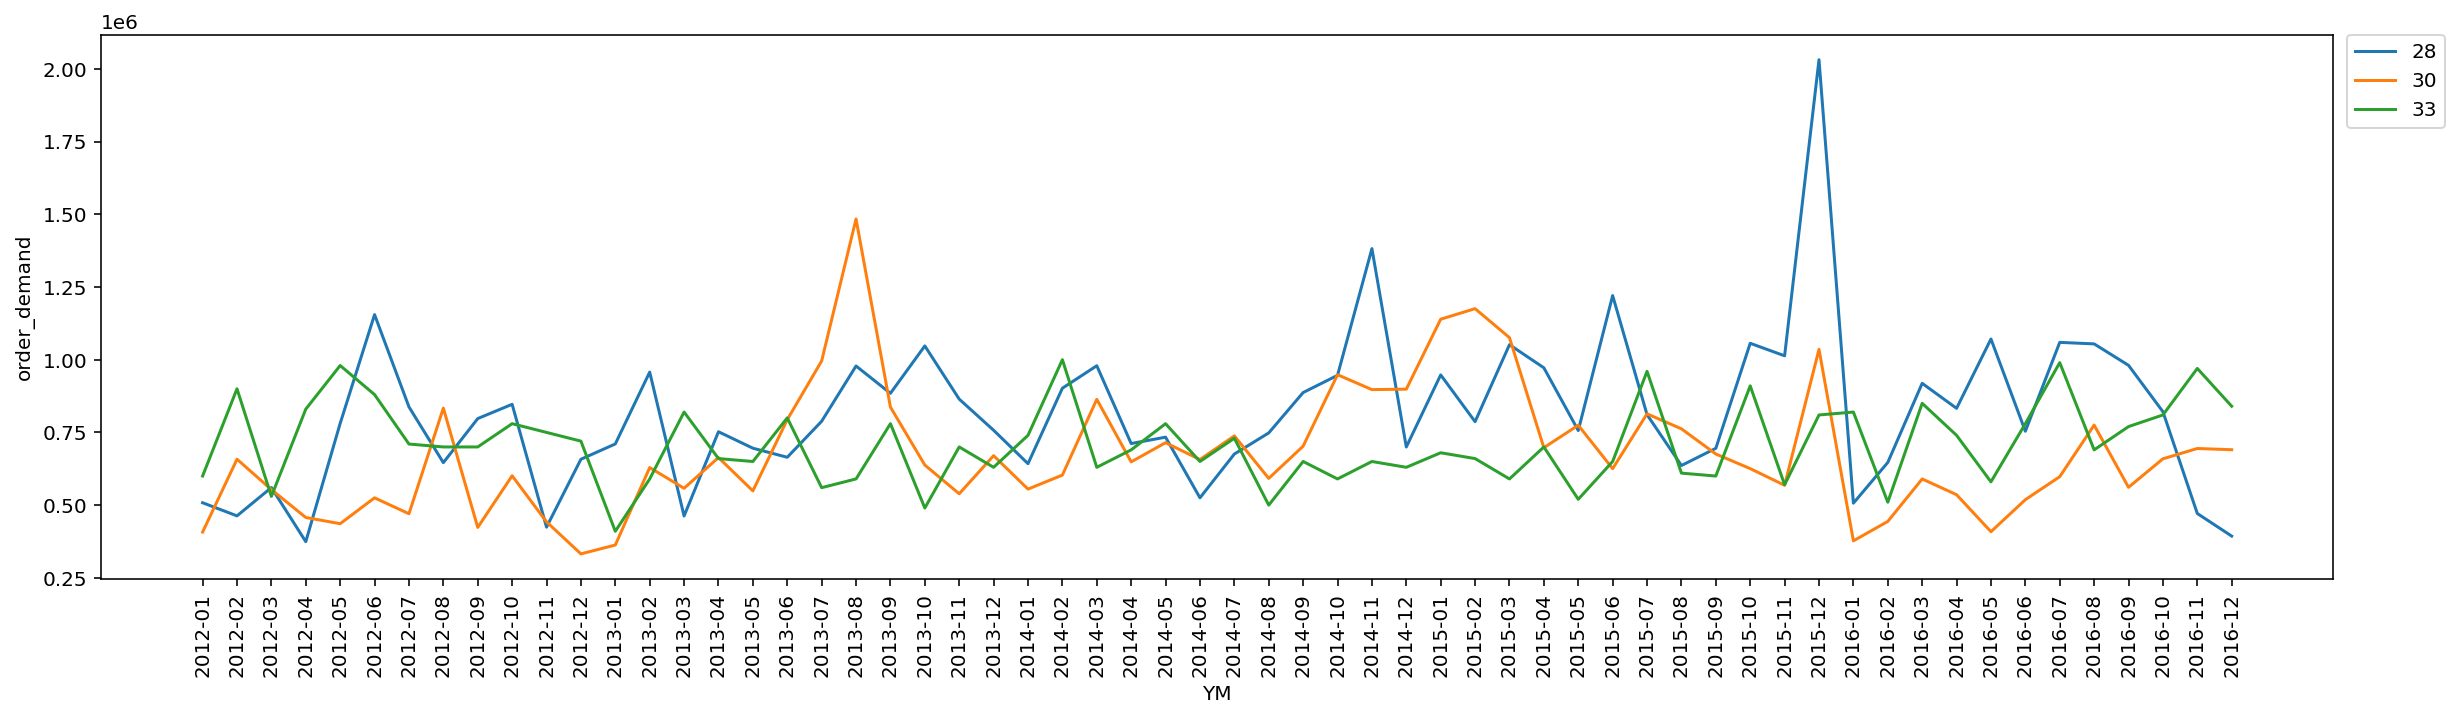

In [48]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=cat_283033, x="YM", y='order_demand', hue='product_category', palette='tab10')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.show();

위 그래프는 카테고리 28, 30, 33의 월별 총 수요량을 시각화한 것이다. 위의 그래프에서 카테고리 28, 30 그리고 33의 증감률이 서로 연관되어 있어 보인다.

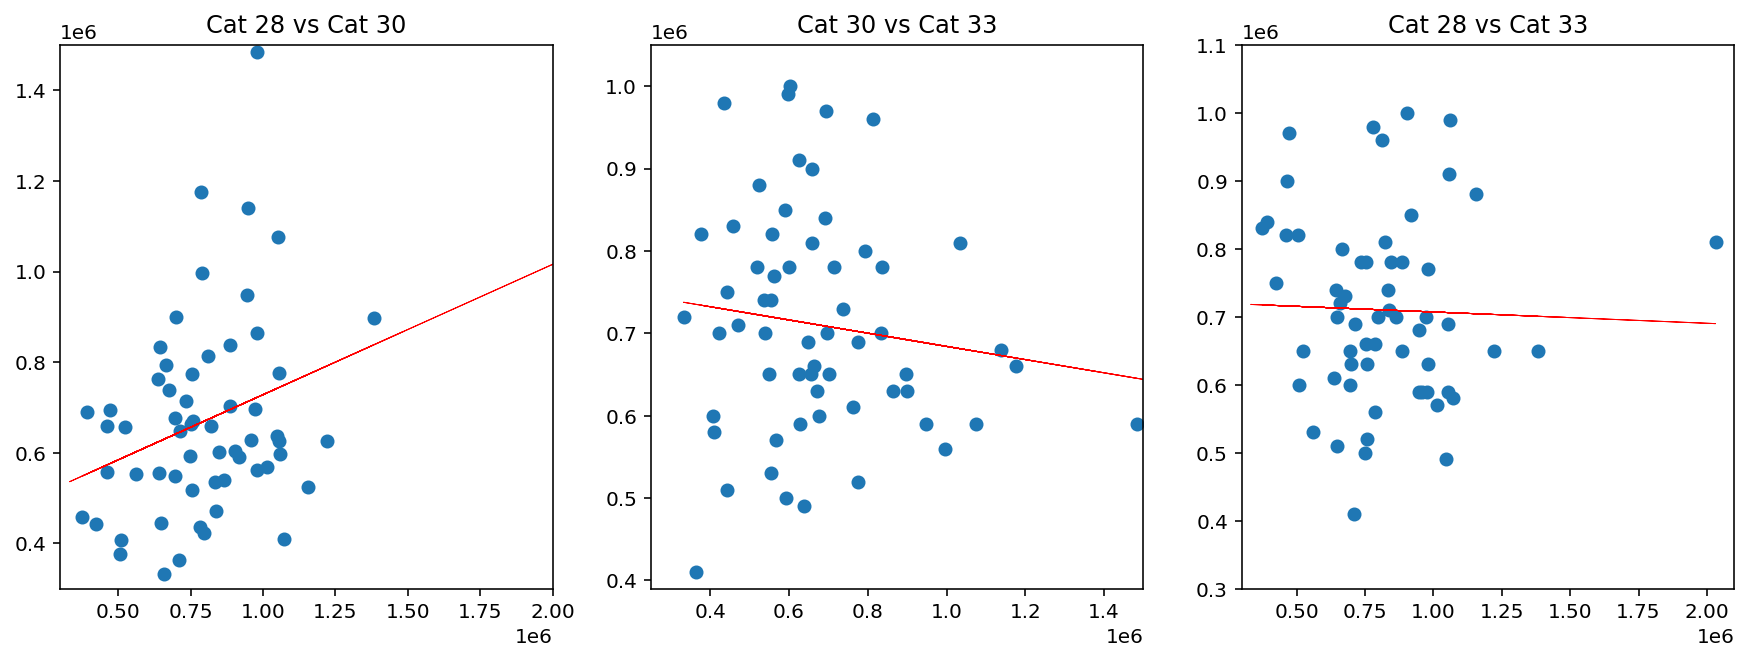

In [49]:
piv_283033 = pd.pivot_table(cat_283033, values='order_demand', index=['YM'], columns=['product_category'], aggfunc=np.sum)

x = piv_283033.reset_index().drop("YM", axis=1)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(piv_283033[28],piv_283033[30])
m, b = np.polyfit(piv_283033[28], piv_283033[30], 1)
plt.plot(x, m*x+b, 'r', linewidth=0.5)
plt.xlim(300000, 2000000)
plt.ylim(300000, 1500000)

plt.title('Cat 28 vs Cat 30')

plt.subplot(132)
plt.scatter(piv_283033[30],piv_283033[33])
m, b = np.polyfit(piv_283033[30], piv_283033[33], 1)
plt.plot(x, m*x+b, 'r', linewidth=0.5)
plt.xlim(250000, 1500000)
plt.ylim(390000, 1050000)

plt.title('Cat 30 vs Cat 33')

plt.subplot(133)
plt.scatter(piv_283033[28],piv_283033[33])
m, b = np.polyfit(piv_283033[28], piv_283033[33], 1)
plt.xlim(300000, 2100000)
plt.ylim(300000, 1100000)
plt.plot(x, m*x+b, 'r', linewidth=0.5)

plt.title('Cat 28 vs Cat 33');

In [50]:
print('Cat 28 vs Cat 30 r-score:',piv_283033[28].corr(piv_283033[30]))
print('Cat 30 vs Cat 33 r-score:',piv_283033[30].corr(piv_283033[33]))
print('Cat 28 vs Cat 33 r-score:',piv_283033[28].corr(piv_283033[33]))

Cat 28 vs Cat 30 r-score: 0.3502254617773807
Cat 30 vs Cat 33 r-score: -0.1291196741151043
Cat 28 vs Cat 33 r-score: -0.03255201625072616


카테고리 28과 30 사이의 r-score는 약 0.35로, 약한 양의 선형 상관관계를 가지고 있다고 할 수 있긴 하지만, 위에서 월별 수요량의 그래프를 봤을 때 기대했던 것보다는 상관관계가 약했다. 그리고 카테고리 30과 33, 카테고리 28, 33 사이에서는 선형 상관관계를 찾을 수 없다.

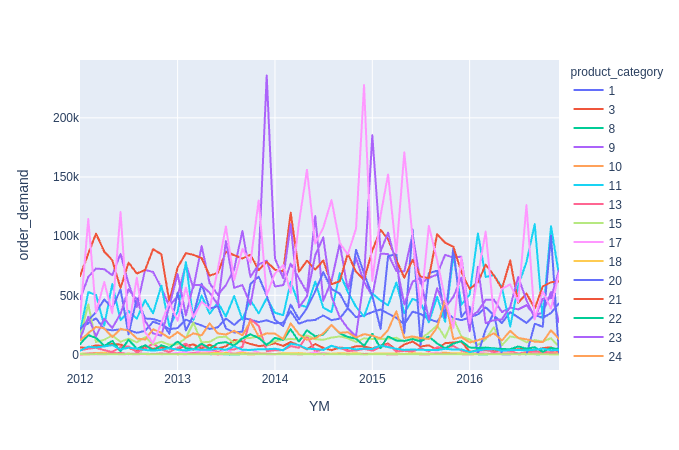

In [51]:
rest = temp_df_month[~temp_df_month['product_category'].isin([5, 6, 7, 28, 30, 33, 19])]

fig = px.line(rest, x="YM", y='order_demand', color='product_category')
fig.show();

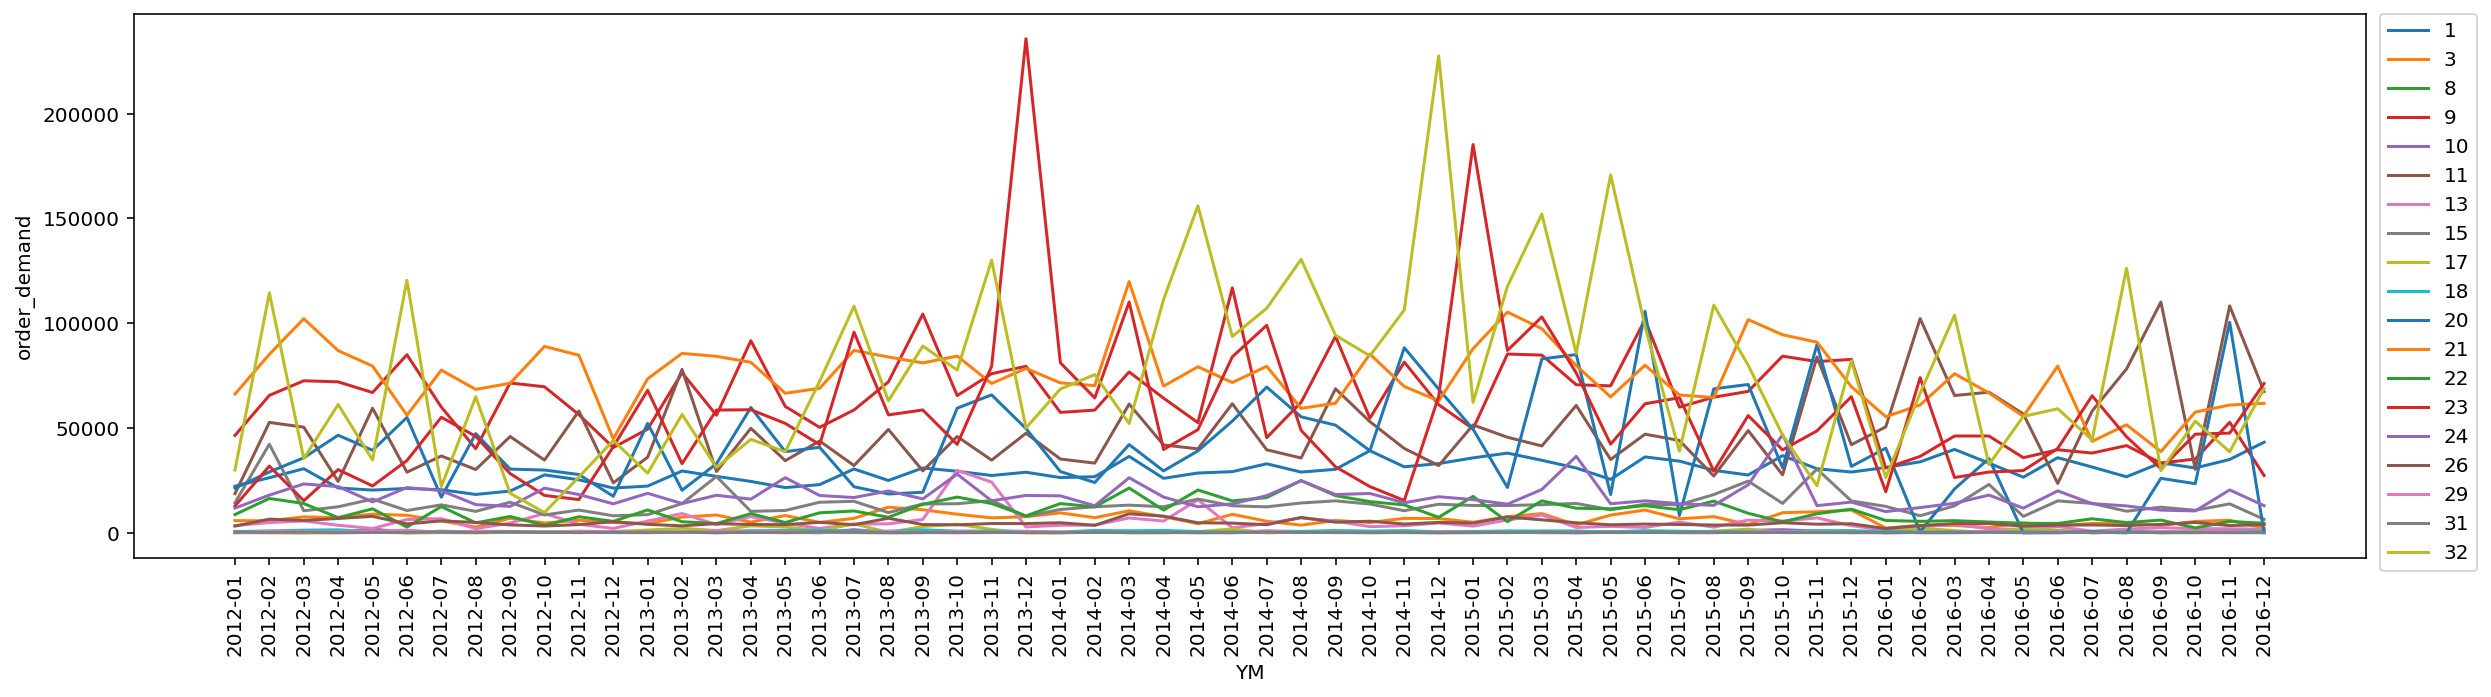

In [52]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=rest, x="YM", y='order_demand', hue='product_category', palette='tab10')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.show();

위 그래프는 판매량이 저조한 카테고리의 월별 판매량을 시각화한 것이다. 위 그래프에서는 그다지 비슷한 트렌드를 보이는 카테고리 쌍이 보이지 않는다. 같은 내용을 시각화 했을 때 어느정도 상관관계가 있을 것 같이 보였던 카테고리 6, 5, 7, 그리고 카테고리 28, 30, 33 사이에서도 강한 상관관계가 존재하지 않았던 것으로 보아, 판매량이 저조한 카테고리들 사이에는 선형 상관관계가 존재하지 않을 것이라고 판단된다.

##### 3) 제품끼리의 상관관계 확인

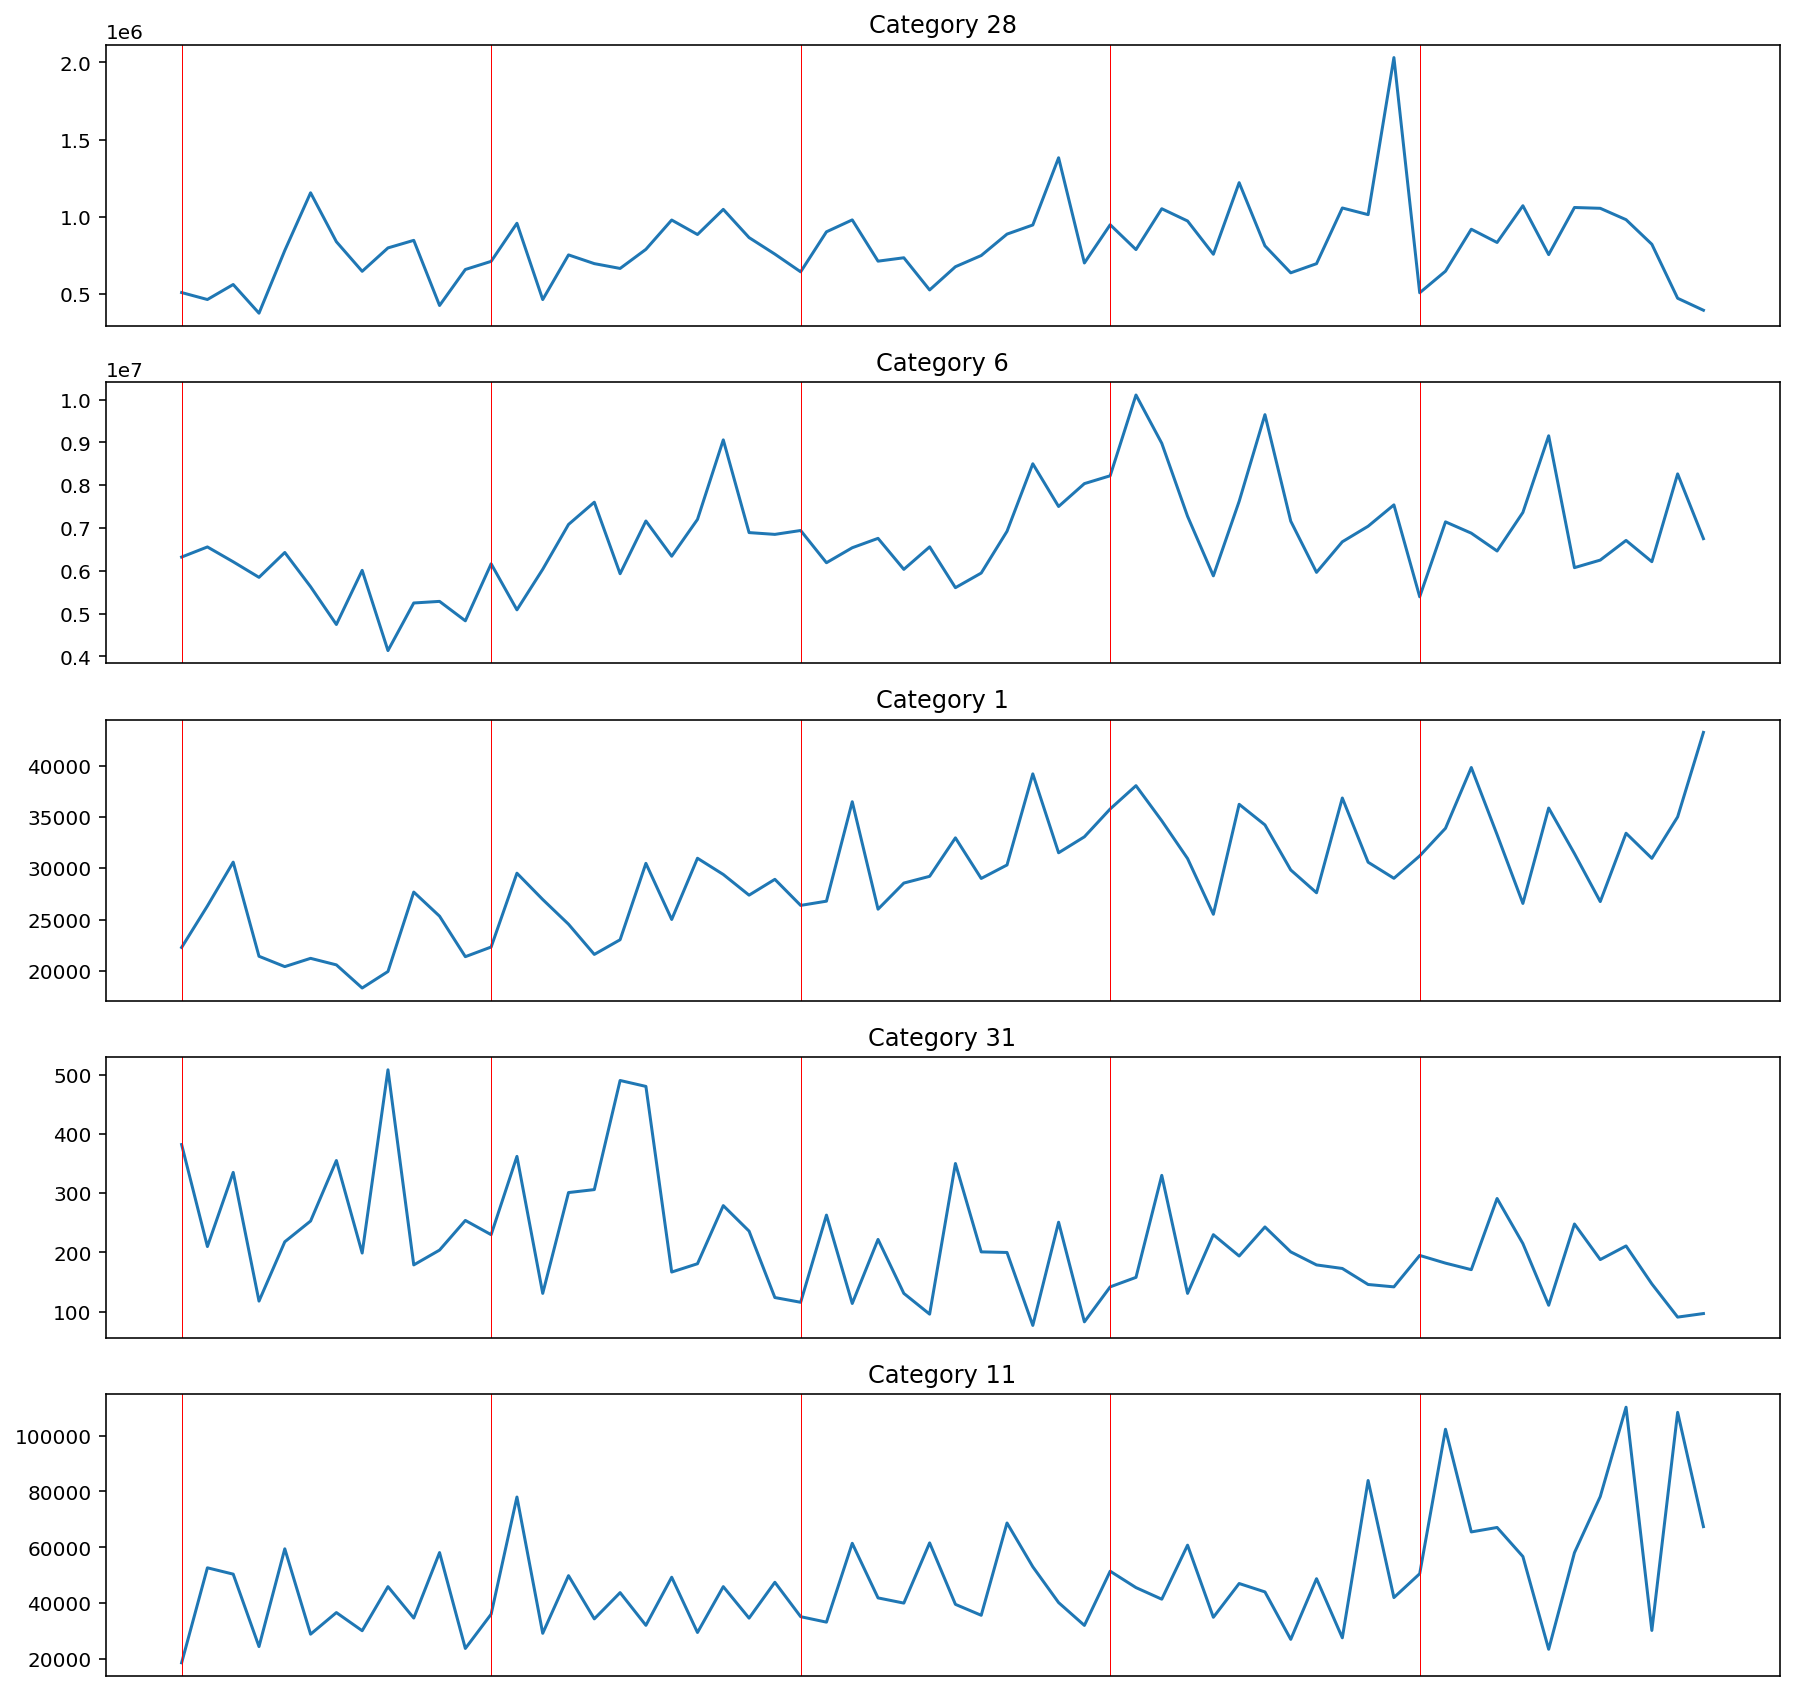

In [53]:
import random
random.seed(42)

plt.figure(figsize=(15, 15))

for idx, cate in enumerate(random.sample(list(temp_df_month['product_category'].unique()), 5)):

    temp = temp_df_month[temp_df_month['product_category'] == cate]

    # 시각화
    plt.subplot(5, 1, idx+1)
    plt.plot(temp['YM'], temp['order_demand'], label=cate)

    plt.axvline(x='2012-01', color='r', linewidth=0.5)
    plt.axvline(x='2013-01', color='r', linewidth=0.5)
    plt.axvline(x='2014-01', color='r', linewidth=0.5)
    plt.axvline(x='2015-01', color='r', linewidth=0.5)
    plt.axvline(x='2016-01', color='r', linewidth=0.5)

    plt.title('Category '+str(cate), fontsize=12)
    plt.xticks([], [])

plt.show();

위에서 카테고리별로 묶어서 관찰하였을 때 반복되는 주기도 찾지 못했고 비슷한 트렌드를 보이는 카테고리도 많이 발견하지 못했다. 카테고리별로 묶어서 보았기 때문이 아닌가 하여 카테고리를 하나만 선정해서 해당 카테고리에 속한 제품들의 월별 수요량을 시각화 해보기로 하였다.


In [54]:
year_month_list = []

for year_str in ['2012', '2013', '2014', '2015', '2016']:
    for month_str in ['01', '02', '03', '04', '05', '06', '07',
                     '08', '09', '10', '11', '12']:
        year_month_list.append(year_str+'-'+month_str)

In [55]:
def plot_by_month_for_product(category):

    global year_month_list
    
    # 같은 카테고리 속 제품 별로 묶기
    temp_df = historical_data[historical_data['product_category'] == category]
    temp_df = temp_df.groupby(['product_code', 'YM']).sum()[['order_demand']].reset_index()

    # 수요량 기록이 없는 기간을 찾아서 0으로 채워넣기
    temp_df = temp_df.pivot(index='YM', columns='product_code', values='order_demand').fillna(0)
    temp_year_month_list = set(temp_df.index)
    zero_year_month_list = set(year_month_list) - temp_year_month_list

    for idx in zero_year_month_list:
        temp_df.loc[idx] = 0

    # 다시 dataframe으로 변경
    temp_df = temp_df.unstack().rename('order_demand').reset_index()

    # 시각화
    plt.figure(figsize=(15, 5))
    for code in temp_df['product_code'].unique():    

        temp = temp_df[temp_df['product_code'] == code]

        # 각 카테고리의 평균, 표준편차
        temp = temp.groupby('YM').sum()[['order_demand']].reset_index()
        temp_mean = temp['order_demand'].mean()
        temp_std = temp['order_demand'].std()

        # 정규화
        temp['order_demand_z'] = temp['order_demand'].apply(lambda x: (x-temp_mean)/temp_std)

        # 시각화
        plt.plot(temp['YM'], temp['order_demand_z'], linewidth=1, label=code, alpha=0.6)

    plt.axvline(x='2012-01', color='r', linewidth=0.5)
    plt.axvline(x='2013-01', color='r', linewidth=0.5)
    plt.axvline(x='2014-01', color='r', linewidth=0.5)
    plt.axvline(x='2015-01', color='r', linewidth=0.5)
    plt.axvline(x='2016-01', color='r', linewidth=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Category '+str(category), fontsize=12)
    plt.xticks(rotation = 90)
    plt.show();

In [56]:
temp_code_cat = historical_data.groupby(['product_code', 'product_category', 'YM']).sum().drop(['year','month','quarter'], axis=1).reset_index()

###### a) 카테고리 29

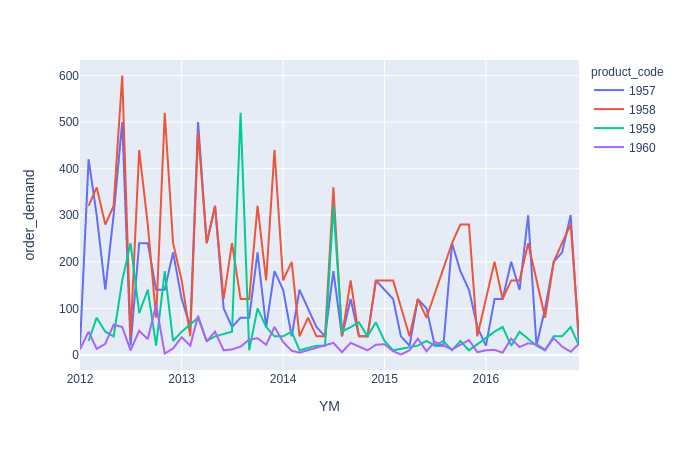

In [57]:
# 카테고리 29에 속하는 제품의 월별 수요량 시각화
cat_29 = temp_code_cat[temp_code_cat['product_category']==29]
piv_29 = pd.pivot_table(cat_29, values='order_demand', index=['YM'], columns=['product_code'], aggfunc=np.sum).fillna(0)

fig = px.line(cat_29, x="YM", y='order_demand', color='product_code')
fig.show();

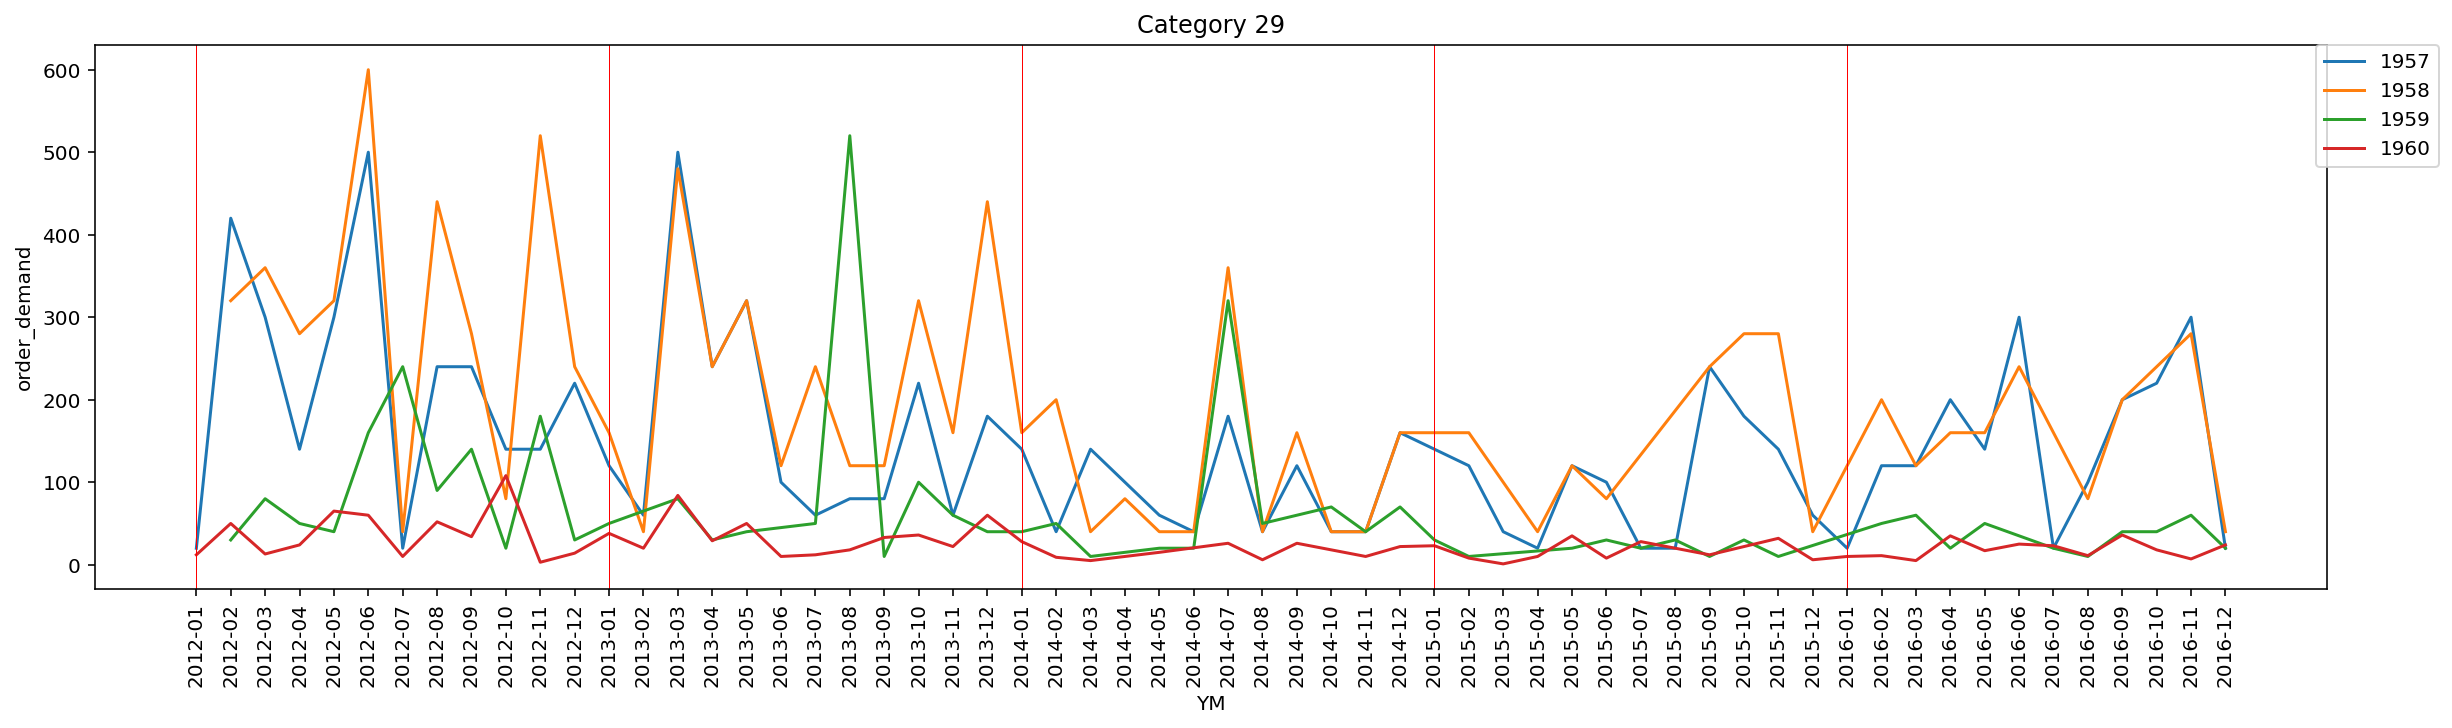

In [58]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=cat_29.sort_values('YM'), x="YM", y='order_demand', hue='product_code', palette='tab10')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.title('Category 29', fontsize=12)
plt.axvline(x='2012-01', color='r', linewidth=0.5)
plt.axvline(x='2013-01', color='r', linewidth=0.5)
plt.axvline(x='2014-01', color='r', linewidth=0.5)
plt.axvline(x='2015-01', color='r', linewidth=0.5)
plt.axvline(x='2016-01', color='r', linewidth=0.5)
plt.show();

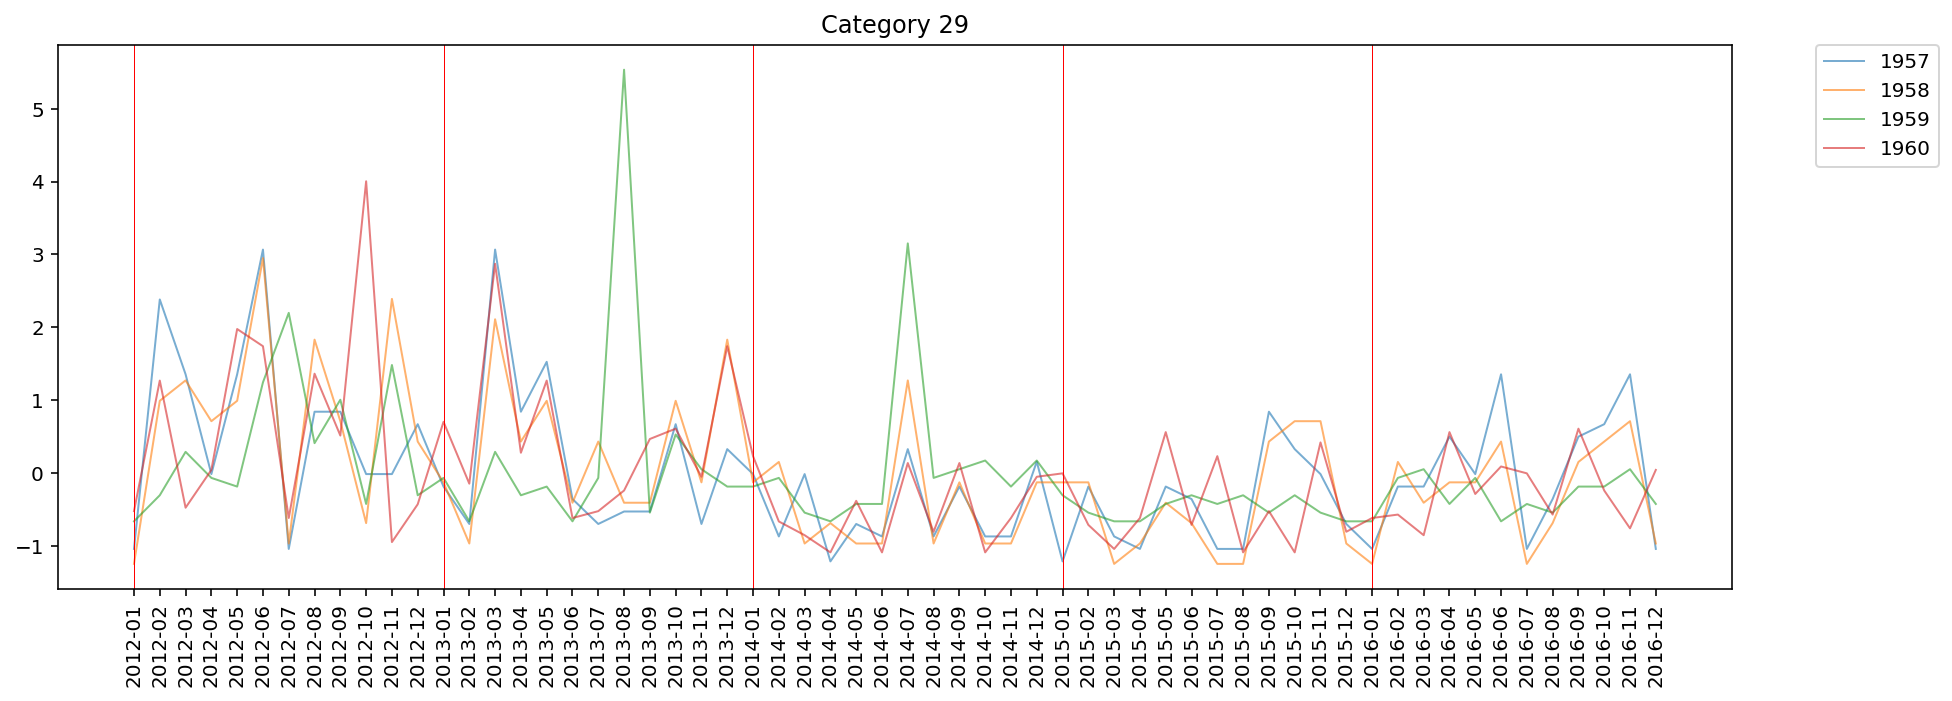

In [59]:
# 각 제품의 주문량을 정규화한 후 시각화
plot_by_month_for_product(29)

Product 1957 vs Product 1958 r-score: 0.8013781797775752


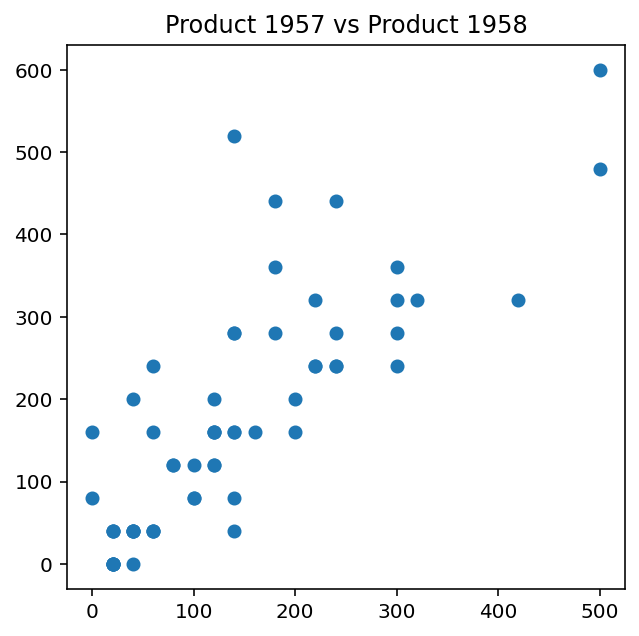

In [60]:
plt.figure(figsize=(5, 5))

plt.scatter(piv_29[1957],piv_29[1958])
plt.title('Product 1957 vs Product 1958')

print('Product 1957 vs Product 1958 r-score:',piv_29[1957].corr(piv_29[1958]))

카테고리 29에 속하는 제품 중 1957번과 1958번의 r-score는 약 0.8로, 둘 사이에는 매우 강한 선형 상관관계가 있다고 할 수 있다.

###### b) 카테고리 33

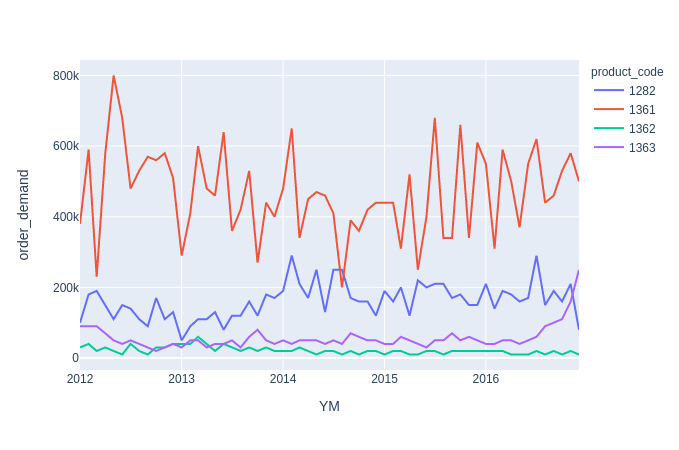

In [61]:
# 카테고리 33에 속하는 제품의 월별 수요량 시각화
cat_33 = temp_code_cat[temp_code_cat['product_category']==33]
piv_33 = pd.pivot_table(cat_33, values='order_demand', index=['YM'], columns=['product_code'], aggfunc=np.sum).fillna(0)

fig = px.line(cat_33, x="YM", y='order_demand', color='product_code')
fig.show();

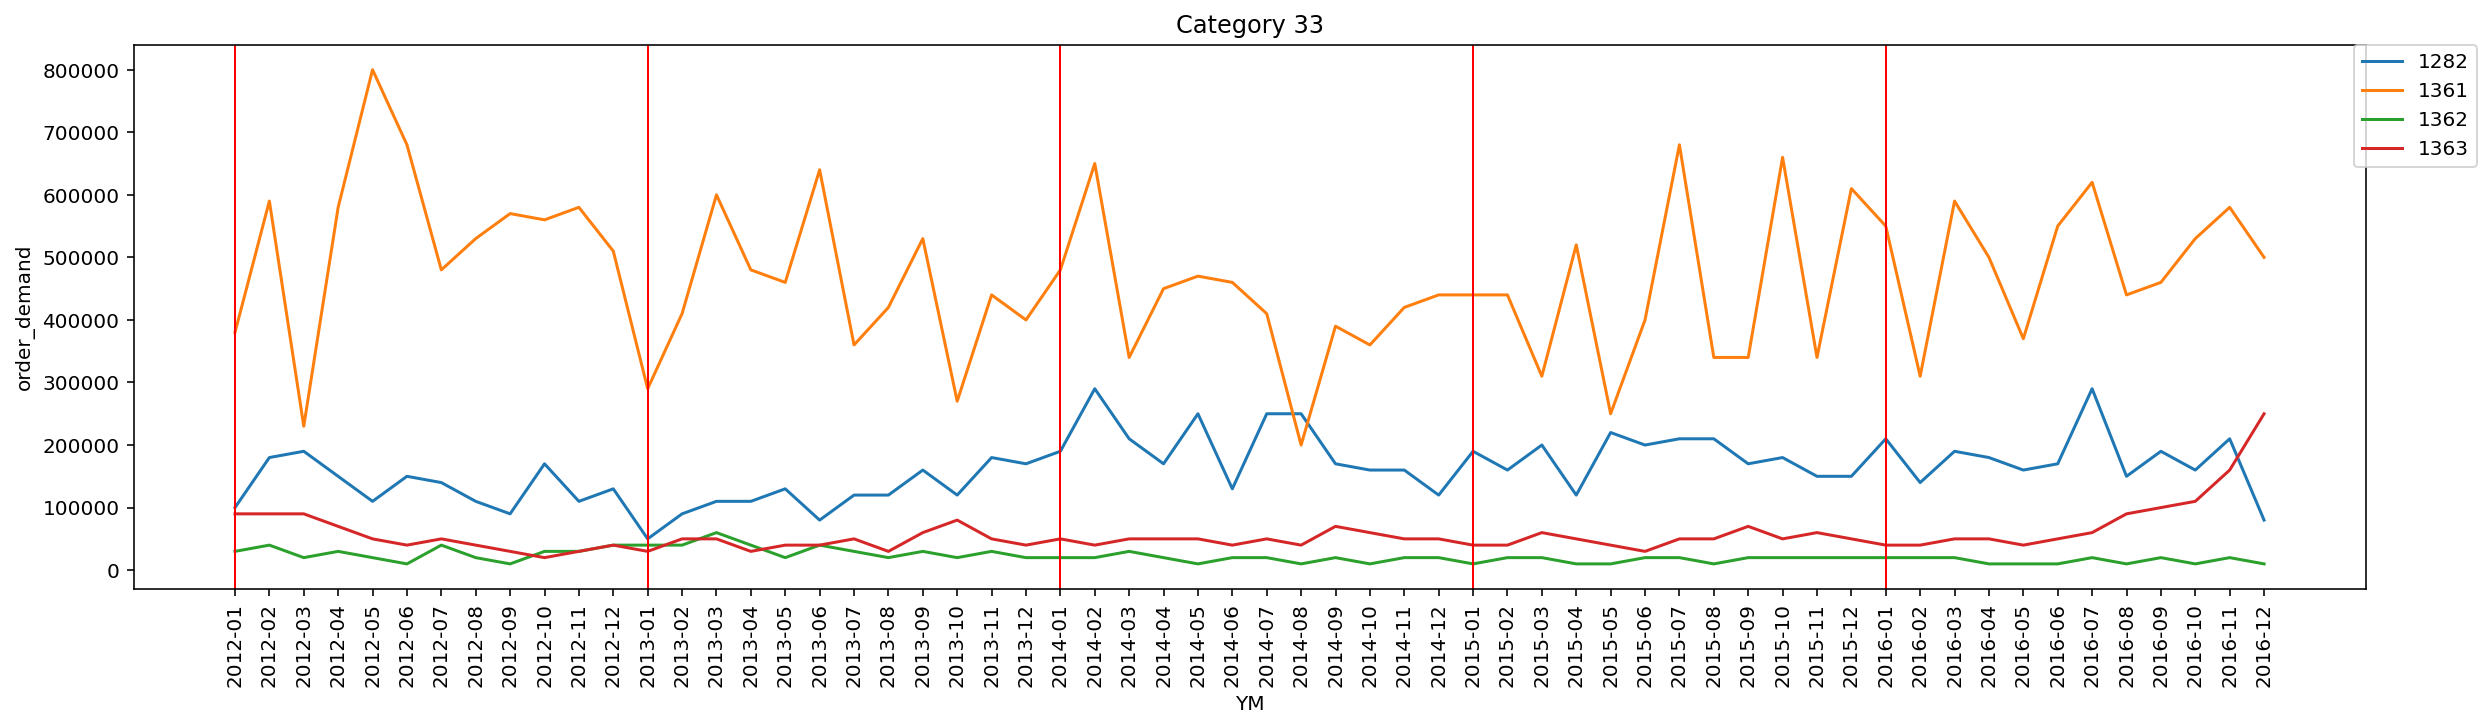

In [62]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=cat_33.sort_values('YM'), x="YM", y='order_demand', hue='product_code', palette='tab10')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.title('Category 33', fontsize=12)
plt.axvline(x='2012-01', color='r', linewidth=1)
plt.axvline(x='2013-01', color='r', linewidth=1)
plt.axvline(x='2014-01', color='r', linewidth=1)
plt.axvline(x='2015-01', color='r', linewidth=1)
plt.axvline(x='2016-01', color='r', linewidth=1)
plt.show();

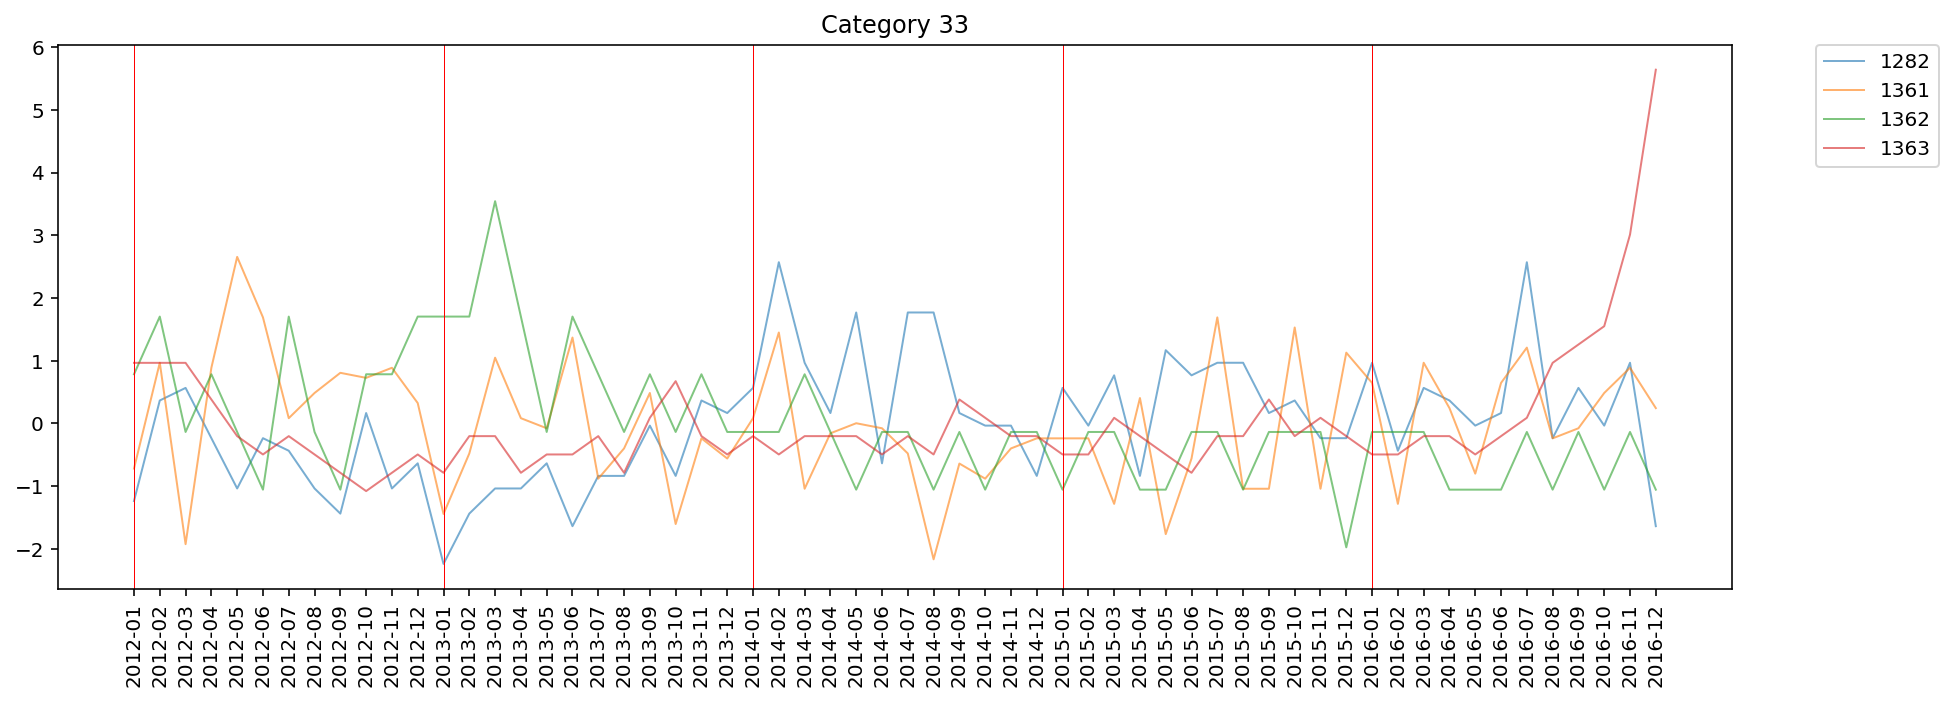

In [63]:
# 각 제품의 주문량을 정규화한 후 시각화
plot_by_month_for_product(33)

Product 1361 vs Product 1282 r-score: -0.039307967542359754
Product 1363 vs Product 1362 r-score: -0.14727487911851803


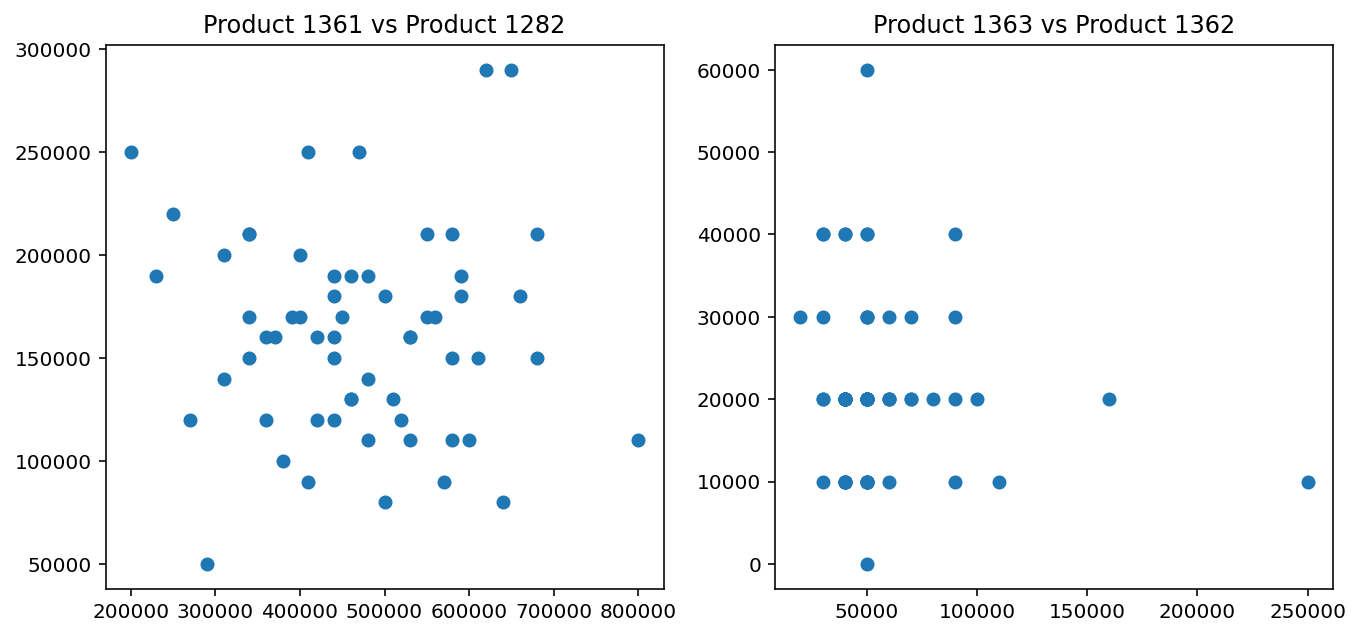

In [64]:
plt.figure(figsize=(11, 5))

plt.subplot(121)
plt.scatter(piv_33[1361],piv_33[1282])
plt.title('Product 1361 vs Product 1282')

print('Product 1361 vs Product 1282 r-score:',piv_33[1361].corr(piv_33[1282]))

plt.subplot(122)
plt.scatter(piv_33[1363],piv_33[1362])
plt.title('Product 1363 vs Product 1362')

print('Product 1363 vs Product 1362 r-score:',piv_33[1363].corr(piv_33[1362]))

###### c) 카테고리 8

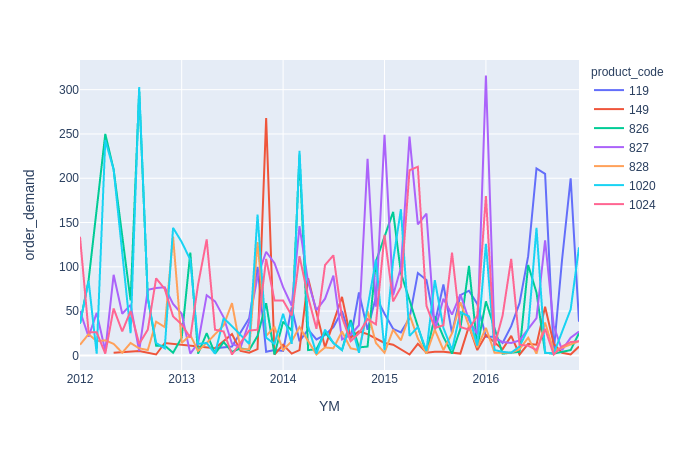

In [65]:
# 카테고리 8에 속하는 제품의 월별 수요량 시각화
cat_8 = temp_code_cat[temp_code_cat['product_category']==8]
piv_8 = pd.pivot_table(cat_8, values='order_demand', index=['YM'], columns=['product_code'], aggfunc=np.sum).fillna(0)

fig = px.line(cat_8, x="YM", y='order_demand', color='product_code')
fig.show();

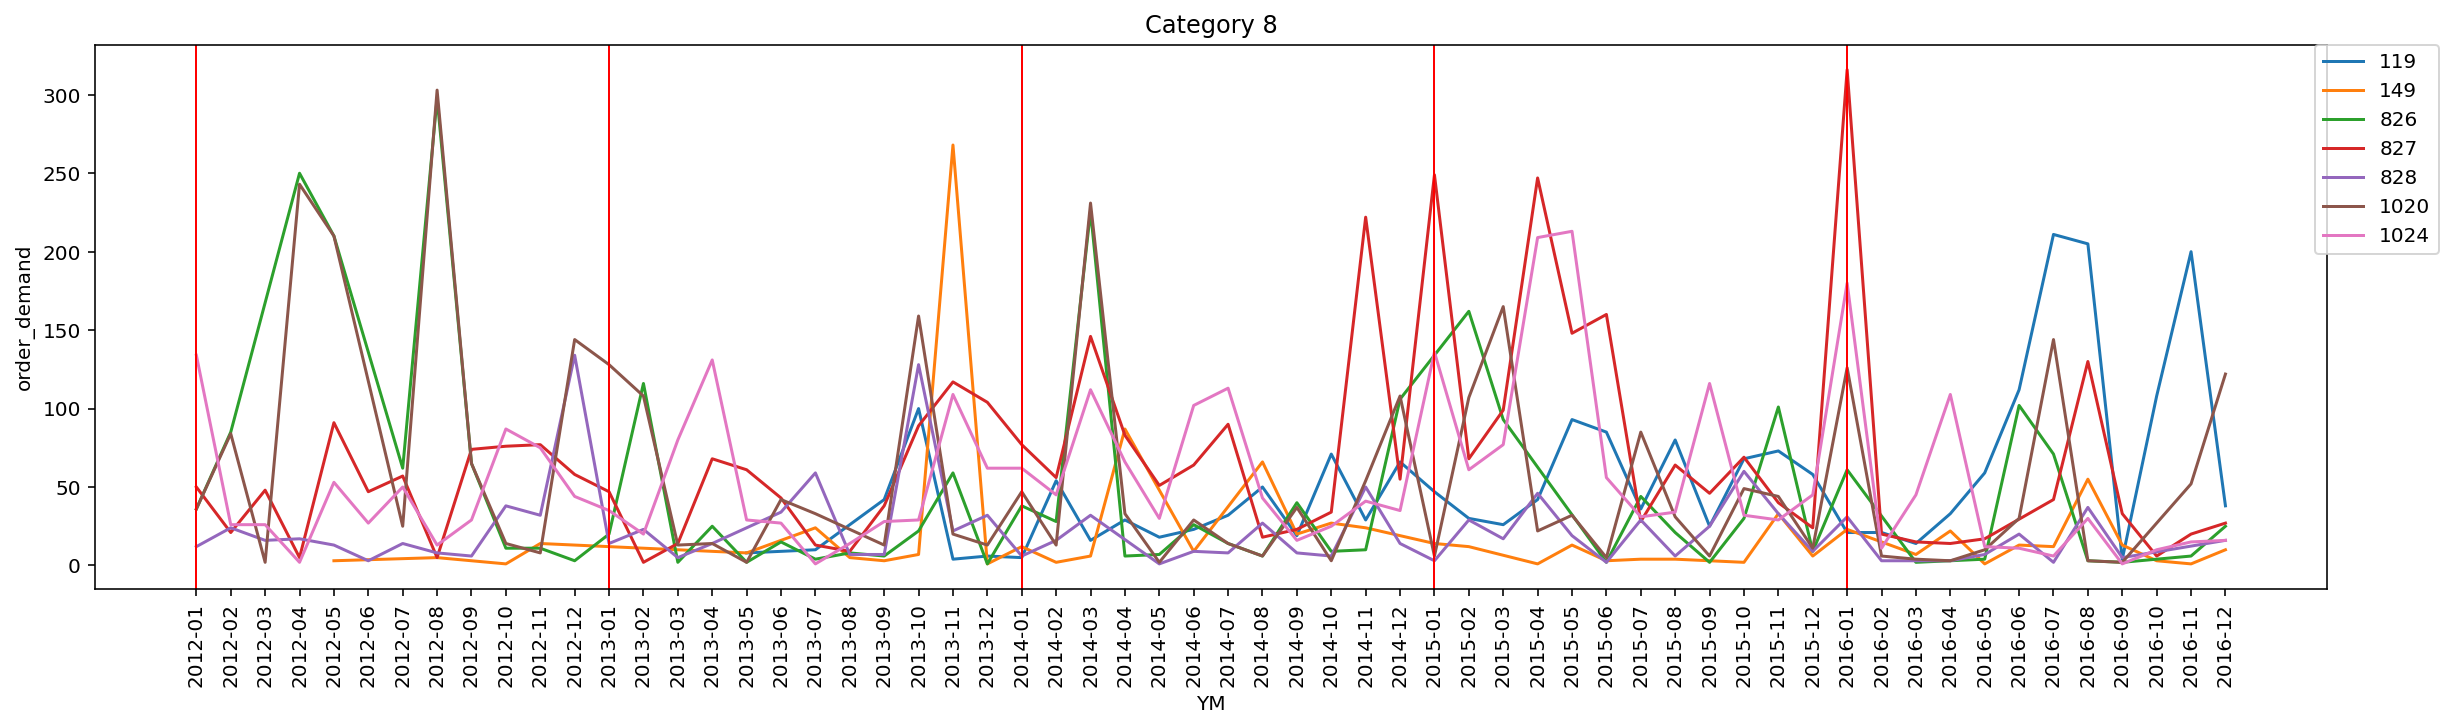

In [66]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=cat_8.sort_values('YM'), x="YM", y='order_demand', hue='product_code', palette='tab10')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.title('Category 8', fontsize=12)
plt.axvline(x='2012-01', color='r', linewidth=1)
plt.axvline(x='2013-01', color='r', linewidth=1)
plt.axvline(x='2014-01', color='r', linewidth=1)
plt.axvline(x='2015-01', color='r', linewidth=1)
plt.axvline(x='2016-01', color='r', linewidth=1)
plt.show();

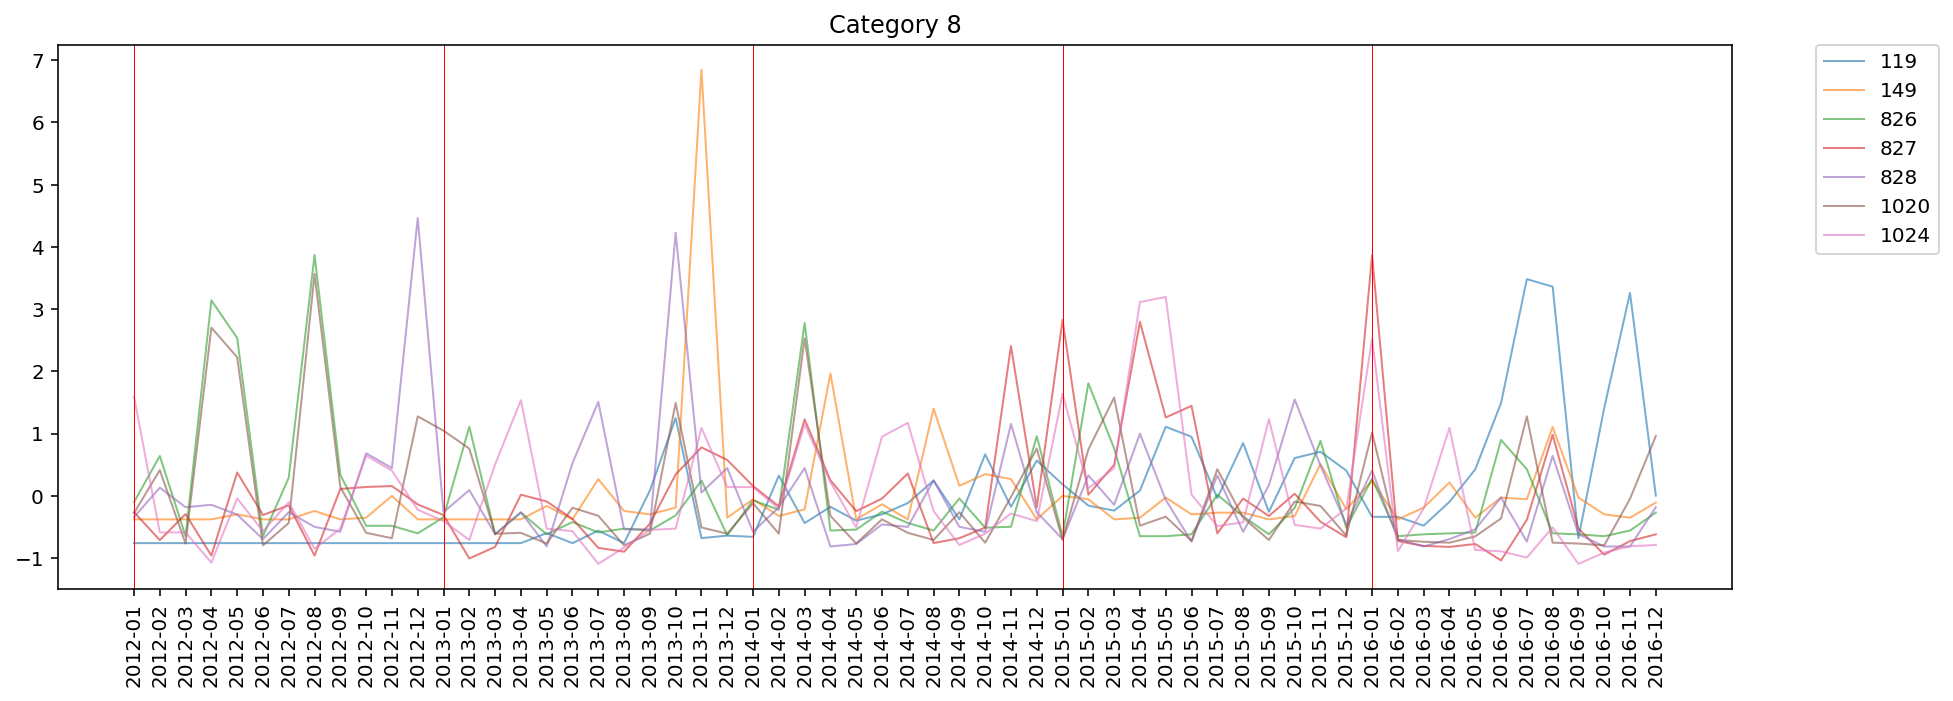

In [67]:
# 각 제품의 주문량을 정규화한 후 시각화
plot_by_month_for_product(8)

Product 827 vs Product 1024 r-score: 0.6731020638763068


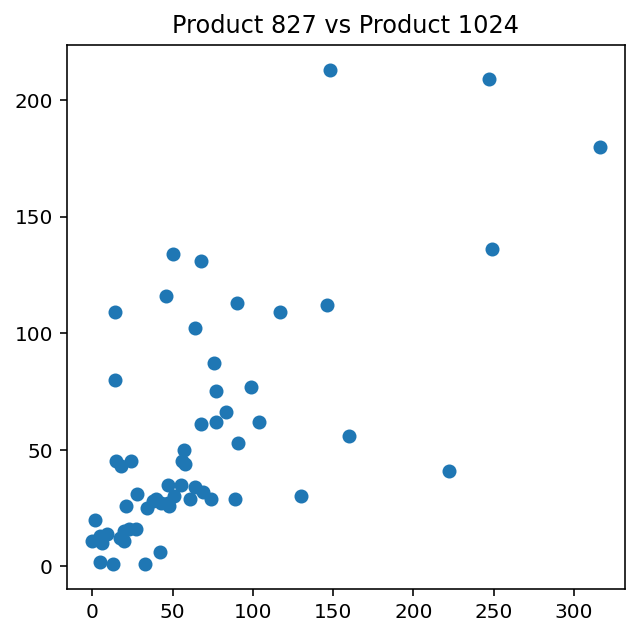

In [68]:
plt.figure(figsize=(5, 5))

plt.scatter(piv_8[827],piv_8[1024])
plt.title('Product 827 vs Product 1024')

print('Product 827 vs Product 1024 r-score:',piv_8[827].corr(piv_8[1024]))


동일한 카테고리 내의 제품 중에서 비슷한 트렌드를 보이는 제품이 존재하긴 했지만, 카테고리가 같다고 해서 모든 제품의 트렌드가 동일한 것은 아니었다.

### 3. 결과 정리

수요량의 추이를 시각화 해봤을 때, 반복되는 주기는 관찰할 수 없었다. 데이터셋을 제공한 회사가 제조 회사라는 것밖에 알 수 없어서 왜 계절에 따른 주기가 나타나지 않았는지 확실히 할 수는 없으나, 화장지, 비누처럼 계절을 타지 않는 제품과 관련된 회사여서 그렇지 않을까 하고 추측하였다.

카테고리별로 수요량의 반복되는 주기를 관찰하려고 하였으나, 주기가 보이지 않아서 같은 카테고리 안에 있는 제품의 수요량도 시각화 해보았다. 하지만 같은 카테고리 안에서도 판매량이 서로 연관되어 보이는 제품도 있고, 전혀 관계가 없는 제품도 있었다.
